Eksperyment 1 ma na celu zbadanie zgodności (i stabilności) macierzy sąsiedztwa uzyskanych:

- z parametrów modelu
- z próbki z modelu

przy zastosowaniu różnych technik dyskretyzacji.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex
import json
import urllib
import datetime
from tqdm import tqdm
import itertools
from scipy.stats import multivariate_normal

from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from pathlib import Path
from hmmlearn import hmm
import sys
PROJECT_PATH = f"/Ziob/kabalce/FlowHMM"
sys.path.insert(1, PROJECT_PATH)
from torchHMM.utils.utils import  total_variance_dist
from torchHMM.model.discretized_HMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim
LEARNING_ALGORITHMS = ["em", "cooc"]

In [2]:
sns.set_style("white")

with urllib.request.urlopen('https://xkcd.com/color/rgb.txt') as f:
    colors = f.readlines()
color_names = [str(c)[2:].split('\\t')[0] for c in colors[1:]]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
np.random.seed(2023)

In [4]:
true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# true_model.startprob_ = np.array([0.6, 0.3, 0.1])
# true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
#
# true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
# true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]])

true_model.startprob_ = np.array([0.6, 0.3, 0.1])
true_model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])

true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
true_model.covars_ = np.array([[[1, -.5], [-.5, 1.2]], [[.6, -.5], [-.5, 1.2]], [[1.5, .5], [.5, 2.2]]]) * .8

In [5]:
X_train, Z_train = true_model.sample(100000)
X_test, Z_test = true_model.sample(1000)

In [6]:
norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
norms = [norm1, norm2, norm3]

Wybór metryk i sposób prezentacji:

1. Oblicz log-likelihood prawdziwego modelu.
2. Dla 25, 100, 400 węzłów:
    - wytrenuj model,
    - podaj metryki zgodności z macierzą Q z danych: KL, d_{tv}
    - podaj metryki zgodności parametrów gaussoid:
        - KL między Gaussoidami - średnia ważona rozkładem początkowym prawdziwego modelu
    - podaj d_tv między macierzami tranzycji i startprobami

In [7]:
def plot_Q_from_model(model_):
    S_ = model_.transmat_ * model_.startprob_[:, np.newaxis]
    distributions_ = [
            scipy.stats.multivariate_normal(model_.means_[i], model_.covars_[i])
            for i in range(model_.n_components)
        ]

    B_ = np.concatenate(
            [
                dist.pdf(model_.nodes.T).reshape(
                    1, -1
                )
                for dist in distributions_
            ],
            axis=0,
        )
    B_ = B_ / B_.sum(1)[:, np.newaxis]
    return B_.T @ S_ @ B_


def init_model(discretize_meth):
    model = DiscreteHMM(discretize_meth, n, n_components=3, learning_alg='cooc', verbose=True, params="stcm", init_params="stcm", covariance_type="full",
                        optim_params=dict(max_epoch=10000, lr=0.1, weight_decay=0), n_iter=100)

    # model.startprob_ = true_model.startprob_
    # model.transmat_ = true_model.transmat_
    # model.means_ = true_model.means_
    # model.covars_ = true_model.covars_
    return model


def plot_true_HMM(X, model, path=None):

    x1, y1 = X.min(axis=0) * 1.1
    x2, y2 = X.max(axis=0) * 1.1

    XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
    data = np.column_stack((XX.ravel(), YY.ravel()))
    lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

    plt.figure(figsize=(5, 5))
    for k in range(model.n_components):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]), levels=8)

    plt.scatter(model.nodes[0], model.nodes[1])
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions")
    if path is not None:
        plt.savefig(path)
    plt.show()

def kl_divergence(p_, q_):
    p = p_.reshape(-1) + 1e-6
    p /= p.sum()
    q = q_.reshape(-1) + 1e-6
    q /= q.sum()
    return np.sum(p * np.log2(p / q))


# https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians
# https://stanford.edu/~jduchi/projects/general_notes.pdf
def kl_div_gaus(mean, covar, mean_gt, covar_gt):
    det1 = np.linalg.det(covar)
    det2 = np.linalg.det(covar_gt)
    d = covar.shape[0]
    covar_gt_inv = np.linalg.inv(covar_gt)
    return .5 * ( np.log(det2 / det1) - d + np.trace(covar_gt_inv @ covar) + (mean_gt - mean).T @ covar_gt_inv @ (mean_gt - mean))

def kl_div_models(model, model_gt):
    return np.sum(np.array([kl_div_gaus(model.means_[i], model.covars_[i], model_gt.means_[i], model_gt.covars_[i]) for i in range(model_gt.n_components)])
                  * model_gt.startprob_)

def acc_perm(Z_hat, Z):
    perm = find_permutation(np.concatenate([Z_hat, np.arange(Z.max())]), np.concatenate([Z, np.arange(Z.max())]))
    return (perm[Z_hat] == Z).mean()

In [8]:
results = list()
Path(f"{PROJECT_PATH}/theoretical_experiment/plots").mkdir(exist_ok=True, parents=True)
for discretize_meth in DISCRETIZATION_TECHNIQUES:
    display(Markdown(f"\n\n## {discretize_meth}"))
    for n in [10, 25, 50, 100, 400]:
        for _ in tqdm(range(20)):
            X, Z = true_model.sample(100000)
            model = init_model(discretize_meth)
            model.fit(X, early_stopping=True)
            Xd = model.discretize(X, False)

            Q_cooc = model._cooccurence(Xd)
            Q_true_model = plot_Q_from_model(model)

            kl_Q = kl_divergence(Q_cooc, Q_true_model)
            dtv_Q = total_variance_dist(Q_cooc, Q_true_model)
            kl_emis = kl_div_models(model, true_model)
            dtv_pi = total_variance_dist(model.startprob_, true_model.startprob_)
            dtv_A = total_variance_dist(model.transmat_, true_model.transmat_)

            results.append({'KL_Q': kl_Q, 'd_tv_Q': dtv_Q,
                            'KL_E': kl_emis,  'd_tv_A': dtv_A, 'd_tv_pi': dtv_pi,
                            'disc': discretize_meth, 'n': n,
                            'll': model.score(X_test), 'acc': acc_perm(model.predict(X_test), Z_test)})

with open(f"{PROJECT_PATH}/theoretical_experiment/2_train_cooc_{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')}.json", 'w') as f:
    json.dump(results, f)



## random

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473361.6156             +nan
         2     -474004.5503        -642.9347
  5%|████████▊                                                                                                                                                                      | 1/20 [00:43<13:42, 43.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450860.6445             +nan
         2     -451191.4504        -330.8059
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:56<07:35, 25.31s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445787.0721             +nan
         2     -462028.5653      -16241.4932
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:08<05:29, 19.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463058.2684             +nan
         2     -461091.6685       +1966.5999
         3     -459355.5587       +1736.1097
         4     -457850.4916       +1505.0672
         5     -456557.1309       +1293.3606
         6     -455448.3406       +1108.7904
         7     -454496.5726        +951.7680
         8     -453677.2529        +819.3196
         9     -452969.7790        +707.4739
        10     -452357.3818        +612.3972
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:10<09:41, 36.33s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -522089.6245             +nan
         2     -515309.9661       +6779.6584
         3     -509607.8194       +5702.1467
         4     -504960.6303       +4647.1891
         5     -501215.0794       +3745.5509
         6     -498189.8220       +3025.2574
         7     -495723.8923       +2465.9297
         8     -493689.5091       +2034.3832
         9     -491989.8638       +1699.6453
        10     -490552.8095       +1437.0543
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [03:13<11:29, 45.99s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446666.9055             +nan
         2     -444222.1684       +2444.7371
         3     -442193.5728       +2028.5956
         4     -441833.5047        +360.0680
         5     -460012.5110      -18179.0062
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:44<09:31, 40.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463501.1452             +nan
         2     -456352.5740       +7148.5712
         3     -449677.3972       +6675.1768
         4     -443743.4593       +5933.9379
         5     -438783.2554       +4960.2039
         6     -435065.4547       +3717.8007
         7     -453625.3331      -18559.8784
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [04:22<08:37, 39.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436702.9654             +nan
         2     -433548.7139       +3154.2515
         3     -434902.8761       -1354.1622
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [04:40<06:34, 32.90s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460826.0101             +nan
         2     -462847.4111       -2021.4010
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:52<04:50, 26.44s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467958.0473             +nan
         2     -470677.2636       -2719.2164
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [05:04<03:40, 22.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462212.1686             +nan
         2     -461695.5098        +516.6588
         3     -462036.3032        -340.7934
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:22<03:07, 20.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511268.7358             +nan
         2     -511205.6191         +63.1167
         3     -511911.0348        -705.4156
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:41<02:42, 20.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488822.5064             +nan
         2     -485575.4604       +3247.0460
         3     -482635.5093       +2939.9510
         4     -480132.1769       +2503.3324
         5     -478051.6565       +2080.5204
         6     -476329.1480       +1722.5085
         7     -474895.5150       +1433.6330
         8     -473692.0764       +1203.4386
         9     -472672.5974       +1019.4789
        10     -471801.4919        +871.1055
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:44<03:51, 33.12s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455877.5152             +nan
         2     -455801.7008         +75.8143
         3     -455812.1511         -10.4502
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:02<02:52, 28.68s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448273.8369             +nan
         2     -446171.9693       +2101.8676
         3     -444125.1519       +2046.8175
         4     -442175.3192       +1949.8327
         5     -440374.0875       +1801.2317
         6     -438780.2047       +1593.8828
         7     -437452.0287       +1328.1760
         8     -436434.5697       +1017.4591
         9     -435745.1406        +689.4290
        10     -435366.3884        +378.7523
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [08:05<03:14, 38.90s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466900.1970             +nan
         2     -479488.6844      -12588.4874
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [08:18<02:04, 31.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449099.6917             +nan
         2     -449279.2443        -179.5525
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [08:30<01:16, 25.46s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494475.5217             +nan
         2     -483237.0880      +11238.4337
         3     -472091.6055      +11145.4826
         4     -460314.4144      +11777.1911
         5     -446370.6035      +13943.8109
         6     -436971.4573       +9399.1462
         7     -479676.1522      -42704.6949
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:12<01:00, 30.23s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486181.7854             +nan
         2     -501002.7397      -14820.9543
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [09:25<00:25, 25.03s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460082.1512             +nan
         2     -457874.5857       +2207.5655
         3     -455893.6854       +1980.9003
         4     -454112.2510       +1781.4345
         5     -452511.5418       +1600.7092
         6     -451076.8836       +1434.6581
         7     -449795.3181       +1281.5655
         8     -448654.4937       +1140.8245
         9     -447642.2691       +1012.2246
        10     -446746.6914        +895.5777
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:31<00:00, 31.56s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436763.6734             +nan
         2     -436594.1638        +169.5096
         3     -436438.7176        +155.4462
         4     -436296.3722        +142.3453
         5     -436166.2045        +130.1677
         6     -436047.3303        +118.8743
         7     -435938.9053        +108.4250
         8     -435840.1269         +98.7784
         9     -435750.2348         +89.8921
        10     -435668.5119         +81.7228
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481540.0814             +nan
         2     -481246.5194        +293.5621
         3     -480970.9808        +275.5385
         4     -480714.4579        +256.5229
         5     -480477.1825        +237.2755
         6     -480258.8516        +218.3309
         7     -480058.7983        +200.0533
         8     -479876.1186        +182.6797
         9     -479709.7661        +166.3525
        10     -479558.6222        +151.1440
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:08<19:10, 63.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434310.8210             +nan
         2     -434049.4947        +261.3263
         3     -433794.0316        +255.4631
         4     -433544.5833        +249.4483
         5     -433301.4497        +243.1336
         6     -433065.0612        +236.3885
         7     -432835.9495        +229.1117
         8     -432614.7085        +221.2410
         9     -432401.9497        +212.7588
        10     -432198.2576        +203.6921
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:10<17:54, 63.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -521896.8107             +nan
         2     -528822.5851       -6925.7743
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:23<11:30, 43.16s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467052.8684             +nan
         2     -466323.3008        +729.5676
         3     -465696.7807        +626.5201
         4     -465157.6966        +539.0842
         5     -464692.8776        +464.8190
         6     -464291.2264        +401.6513
         7     -463943.3954        +347.8310
         8     -463641.5087        +301.8867
         9     -463378.9244        +262.5843
        10     -463150.0346        +228.8899
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:21<12:08, 48.59s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471770.8454             +nan
         2     -471449.7278        +321.1176
         3     -471162.0056        +287.7222
         4     -470903.9989        +258.0067
         5     -470672.4819        +231.5170
         6     -470464.6169        +207.8649
         7     -470277.8996        +186.7173
         8     -470110.1129        +167.7867
         9     -469959.2892        +150.8238
        10     -469823.6778        +135.6113
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:26<12:40, 54.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454156.0731             +nan
         2     -454259.6667        -103.5936
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:39<08:50, 40.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444560.8587             +nan
         2     -444421.6932        +139.1655
         3     -444297.6063        +124.0869
         4     -444186.8478        +110.7586
         5     -444087.8941         +98.9537
         6     -443999.4147         +88.4794
         7     -443920.2438         +79.1709
         8     -443849.3568         +70.8870
         9     -443785.8511         +63.5057
        10     -443728.9297         +56.9214
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:43<09:37, 48.12s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471766.5461             +nan
         2     -473549.1854       -1782.6394
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:56<06:49, 37.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462600.3262             +nan
         2     -462432.7454        +167.5808
         3     -462280.4997        +152.2456
         4     -462142.3696        +138.1301
         5     -462017.1878        +125.1818
         6     -461903.8497        +113.3381
         7     -461801.3187        +102.5310
         8     -461708.6290         +92.6897
         9     -461624.8858         +83.7431
        10     -461549.2642         +75.6216
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:57<07:23, 44.37s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462108.9210             +nan
         2     -462208.5883         -99.6673
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:08<05:09, 34.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493828.8977             +nan
         2     -502888.4599       -9059.5623
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:21<03:42, 27.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454186.9496             +nan
         2     -454176.6283         +10.3213
         3     -454168.1800          +8.4484
         4     -454161.2663          +6.9136
         5     -454155.6092          +5.6571
         6     -454150.9801          +4.6291
         7     -454147.1915          +3.7886
         8     -454144.0900          +3.1015
         9     -454141.5499          +2.5401
        10     -454139.4686          +2.0813
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [09:24<04:29, 38.46s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449652.6153             +nan
         2     -451123.7321       -1471.1168
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [09:37<03:04, 30.77s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445977.2729             +nan
         2     -445839.7132        +137.5597
         3     -445717.9440        +121.7692
         4     -445609.2083        +108.7357
         5     -445511.3121         +97.8962
         6     -445422.5435         +88.7686
         7     -445341.5854         +80.9581
         8     -445267.4311         +74.1543
         9     -445199.3093         +68.1218
        10     -445136.6216         +62.6877
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [10:40<03:21, 40.39s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457975.6587             +nan
         2     -457777.1139        +198.5448
         3     -457630.5787        +146.5352
         4     -458174.5727        -543.9940
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [11:05<02:23, 35.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447331.1095             +nan
         2     -447259.7742         +71.3353
         3     -447198.1412         +61.6330
         4     -447144.8883         +53.2529
         5     -447098.8570         +46.0313
         6     -447059.0388         +39.8182
         7     -447024.5603         +34.4785
         8     -446994.6684         +29.8919
         9     -446968.7161         +25.9523
        10     -446946.1490         +22.5671
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [12:08<02:12, 44.17s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439001.5376             +nan
         2     -438058.3492        +943.1884
         3     -436380.7744       +1677.5748
         4     -434387.3936       +1993.3807
         5     -435905.6698       -1518.2762
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [12:39<01:20, 40.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -498309.7353             +nan
         2     -500001.6586       -1691.9232
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [12:52<00:31, 31.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461338.6932             +nan
         2     -460925.7311        +412.9621
         3     -460573.0413        +352.6898
         4     -460271.1197        +301.9216
         5     -460012.0365        +259.0832
         6     -459789.1722        +222.8643
         7     -459596.9961        +192.1761
         8     -459430.8808        +166.1152
         9     -459286.9490        +143.9319
        10     -459161.9455        +125.0035
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:55<00:00, 41.80s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454587.7847             +nan
         2     -454538.8703         +48.9145
         3     -454495.0786         +43.7917
         4     -454455.8576         +39.2210
         5     -454420.7173         +35.1404
         6     -454389.2219         +31.4953
         7     -454360.9844         +28.2375
         8     -454335.6599         +25.3245
         9     -454312.9415         +22.7184
        10     -454292.5556         +20.3859
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447939.9314             +nan
         2     -447937.7851          +2.1462
         3     -447935.7204          +2.0647
         4     -447933.7074          +2.0130
         5     -447931.7460          +1.9614
         6     -447929.8497          +1.8962
         7     -447928.0362          +1.8136
         8     -447926.3212          +1.7150
         9     -447924.7165          +1.6047
        10     -447923.2290          +1.4875
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:06<19:00, 63.34s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -430055.6438             +nan
         2     -429949.7039        +105.9399
         3     -429849.2844        +100.4195
         4     -429754.9787         +94.3057
         5     -429667.2160         +87.7627
         6     -429586.2376         +80.9784
         7     -429512.0961         +74.1415
         8     -429444.6739         +67.4221
         9     -429383.7150         +60.9590
        10     -429328.8606         +54.8544
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:09<17:48, 62.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460168.6092             +nan
         2     -460180.2887         -11.6795
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:21<11:27, 42.96s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455228.8821             +nan
         2     -455178.5326         +50.3495
         3     -455132.7982         +45.7344
         4     -455091.2946         +41.5036
         5     -455053.6620         +37.6326
         6     -455019.5652         +34.0968
         7     -454988.6928         +30.8723
         8     -454960.7570         +27.9358
         9     -454935.4923         +25.2647
        10     -454912.6545         +22.8378
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:21<12:14, 48.98s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -518578.7276             +nan
         2     -518499.7058         +79.0218
         3     -518428.8026         +70.9032
         4     -518365.1654         +63.6372
         5     -518308.0345         +57.1308
         6     -518256.7326         +51.3020
         7     -518210.6548         +46.0778
         8     -518169.2610         +41.3938
         9     -518132.0685         +37.1925
        10     -518098.6453         +33.4231
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:22<12:24, 53.15s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476635.5347             +nan
         2     -476446.0185        +189.5162
         3     -476274.9602        +171.0583
         4     -476120.6073        +154.3529
         5     -475981.3652        +139.2421
         6     -475855.7842        +125.5809
         7     -475742.5482        +113.2360
         8     -475640.4631        +102.0851
         9     -475548.4465         +92.0165
        10     -475465.5183         +82.9283
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:25<12:14, 56.47s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436419.5425             +nan
         2     -436439.8487         -20.3062
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:38<08:29, 42.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473853.0542             +nan
         2     -473960.8147        -107.7604
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:50<06:05, 33.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455667.5113             +nan
         2     -455568.5287         +98.9826
         3     -455479.0249         +89.5038
         4     -455398.1288         +80.8961
         5     -455325.0426         +73.0862
         6     -455259.0369         +66.0057
         7     -455199.4458         +59.5911
         8     -455145.6624         +53.7834
         9     -455097.1339         +48.5284
        10     -455053.3580         +43.7759
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:53<07:03, 42.37s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458796.0075             +nan
         2     -458903.8219        -107.8144


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:06<05:00, 33.37s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437538.4494             +nan
         2     -437536.0556          +2.3938
         3     -437534.8551          +1.2004
         4     -437534.5670          +0.2881
         5     -437534.9642          -0.3971


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:35<04:16, 32.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -478393.9246             +nan
         2     -478185.1749        +208.7498
         3     -477997.5697        +187.6051
         4     -477828.9466        +168.6232
         5     -477677.3673        +151.5793
         6     -477541.0946        +136.2727
         7     -477418.5707        +122.5239
         8     -477308.3985        +110.1723
         9     -477209.3244         +99.0740
        10     -477120.2238         +89.1006
 65%|██████████████████████████████████████████████████████████████████████████

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454446.4664             +nan
         2     -454493.4215         -46.9551
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [09:46<03:09, 31.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481236.9655             +nan
         2     -481057.9734        +178.9920
         3     -480896.9762        +160.9972
         4     -480752.1606        +144.8155
         5     -480621.8964        +130.2643
         6     -480504.7175        +117.1789
         7     -480399.3060        +105.4115
         8     -480304.4771         +94.8289
         9     -480219.1655         +85.3116
        10     -480142.4137         +76.7518
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [10:49<03:26, 41.23s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471828.8128             +nan
         2     -471772.0114         +56.8014
         3     -471720.9156         +51.0958
         4     -471674.9500         +45.9656
         5     -471633.5979         +41.3521
         6     -471596.3946         +37.2032
         7     -471562.9229         +33.4717
         8     -471532.8074         +30.1155
         9     -471505.7108         +27.0966
        10     -471481.3298         +24.3810
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [11:56<03:15, 48.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453484.2707             +nan
         2     -453443.5293         +40.7414
         3     -453407.0355         +36.4938
         4     -453374.3313         +32.7041
         5     -453345.0111         +29.3202
         6     -453318.7147         +26.2964
         7     -453295.1222         +23.5925
         8     -453273.9492         +21.1731
         9     -453254.9421         +19.0071
        10     -453237.8751         +17.0670
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [12:56<02:36, 52.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -510708.8296             +nan
         2     -510520.0062        +188.8234
         3     -510350.0134        +169.9927
         4     -510196.9809        +153.0325
         5     -510059.2220        +137.7589
         6     -509935.2166        +124.0054
         7     -509823.5947        +111.6220
         8     -509723.1219        +100.4728
         9     -509632.6864         +90.4355
        10     -509551.2868         +81.3996
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [13:56<01:49, 54.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490925.1705             +nan
         2     -491165.0576        -239.8871
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:07<00:41, 41.68s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481194.6424             +nan
         2     -481299.3023        -104.6598
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [14:21<00:00, 43.06s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449670.8015             +nan
         2     -449662.4003          +8.4012
         3     -449654.8281          +7.5721
         4     -449648.0043          +6.8239
         5     -449641.8556          +6.1487
         6     -449636.3159          +5.5397
         7     -449631.3255          +4.9904
         8     -449626.8303          +4.4952
         9     -449622.7816          +4.0487
        10     -449619.1353          +3.6463


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:01<19:37, 61.98s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486926.1041             +nan
         2     -486927.0185          -0.9144


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:15<09:59, 33.33s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451178.8807             +nan
         2     -451174.1213          +4.7593
         3     -451169.8428          +4.2785
         4     -451165.9959          +3.8469
         5     -451162.5365          +3.4594
         6     -451159.4252          +3.1113
         7     -451156.6268          +2.7985
         8     -451154.1095          +2.5173
         9     -451151.8449          +2.2646
        10     -451149.8075          +2.0374


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:18<13:18, 46.94s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494681.4137             +nan
         2     -494676.0803          +5.3334
         3     -494671.3226          +4.7577
         4     -494667.0750          +4.2476
         5     -494663.2800          +3.7951
         6     -494659.8869          +3.3930
         7     -494656.8514          +3.0355
         8     -494654.1342          +2.7172
         9     -494651.7007          +2.4335
        10     -494649.5202          +2.1805


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:22<14:20, 53.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465259.5857             +nan
         2     -465246.1566         +13.4291
         3     -465234.0694         +12.0872
         4     -465223.1901         +10.8793
         5     -465213.3980          +9.7921
         6     -465204.5845          +8.8135
         7     -465196.6519          +7.9326
         8     -465189.5123          +7.1397
         9     -465183.0863          +6.4260
        10     -465177.3026          +5.7836


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:26<14:20, 57.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437944.5665             +nan
         2     -437943.3967          +1.1698
         3     -437942.3174          +1.0792
         4     -437941.3244          +0.9930
         5     -437940.4129          +0.9115
         6     -437939.5780          +0.8349
         7     -437938.8146          +0.7633
         8     -437938.1179          +0.6967
         9     -437937.4830          +0.6349
        10     -437936.9052          +0.5778


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:23<13:20, 57.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480914.4253             +nan
         2     -480958.3013         -43.8760


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:36<09:16, 42.80s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450116.0530             +nan
         2     -450106.5195          +9.5335
         3     -450097.9458          +8.5738
         4     -450090.2345          +7.7112
         5     -450083.2986          +6.9359
         6     -450077.0597          +6.2389
         7     -450071.4474          +5.6123
         8     -450066.3985          +5.0489
         9     -450061.8563          +4.5422
        10     -450057.7698          +4.0865


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:40<09:56, 49.70s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501471.2852             +nan
         2     -501468.4376          +2.8476
         3     -501465.8967          +2.5410
         4     -501463.6275          +2.2692
         5     -501461.5996          +2.0279
         6     -501459.7862          +1.8134
         7     -501458.1636          +1.6226
         8     -501456.7109          +1.4527
         9     -501455.4097          +1.3012
        10     -501454.2436          +1.1661


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:41<09:43, 53.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442895.3114             +nan
         2     -442888.3797          +6.9317
         3     -442882.1442          +6.2356
         4     -442876.5345          +5.6096
         5     -442871.4878          +5.0467
         6     -442866.9474          +4.5405
         7     -442862.8622          +4.0851
         8     -442859.1866          +3.6756
         9     -442855.8794          +3.3072
        10     -442852.9036          +2.9758


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:45<09:24, 56.44s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438282.5907             +nan
         2     -438275.3668          +7.2239
         3     -438268.8654          +6.5014
         4     -438263.0143          +5.8511
         5     -438257.7484          +5.2659
         6     -438253.0092          +4.7392
         7     -438248.7440          +4.2652
         8     -438244.9054          +3.8386
         9     -438241.4508          +3.4547
        10     -438238.3416          +3.1091


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [09:45<08:37, 57.45s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448287.5064             +nan
         2     -448291.0050          -3.4986


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [09:57<05:49, 43.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438733.4233             +nan
         2     -438726.1668          +7.2566
         3     -438719.6661          +6.5007
         4     -438713.8400          +5.8260
         5     -438708.6166          +5.2234
         6     -438703.9318          +4.6848
         7     -438699.7287          +4.2031
         8     -438695.9567          +3.7720
         9     -438692.5705          +3.3861
        10     -438689.5301          +3.0404


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [10:58<05:42, 48.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481639.7783             +nan
         2     -481557.3689         +82.4094
         3     -481483.1657         +74.2032
         4     -481416.3557         +66.8099
         5     -481356.2057         +60.1500
         6     -481302.0542         +54.1515
         7     -481253.3049         +48.7493
         8     -481209.4204         +43.8845
         9     -481169.9163         +39.5040
        10     -481134.3564         +35.5599


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [12:01<05:19, 53.27s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457352.2456             +nan
         2     -457357.5057          -5.2601


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:14<03:25, 41.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491321.8588             +nan
         2     -491376.2754         -54.4166


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [12:27<02:10, 32.66s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457686.9179             +nan
         2     -457682.8747          +4.0432
         3     -457679.2227          +3.6520
         4     -457675.9252          +3.2975
         5     -457672.9487          +2.9765
         6     -457670.2628          +2.6859
         7     -457667.8397          +2.4231
         8     -457665.6543          +2.1855
         9     -457663.6835          +1.9707
        10     -457661.9067          +1.7768


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [13:31<02:06, 42.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502320.8637             +nan
         2     -502221.1859         +99.6778
         3     -502131.4886         +89.6973
         4     -502050.7723         +80.7163
         5     -501978.1373         +72.6350
         6     -501912.7741         +65.3632
         7     -501853.9542         +58.8199
         8     -501801.0223         +52.9319
         9     -501753.3885         +47.6338
        10     -501710.5223         +42.8662


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:28<01:32, 46.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455733.2158             +nan
         2     -455733.2794          -0.0636


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:41<00:36, 36.35s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462256.5222             +nan
         2     -462316.0452         -59.5230


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -524988.4810             +nan
         2     -524993.4013          -4.9203


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [00:14<04:39, 14.70s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439505.2428             +nan
         2     -439504.8893          +0.3535
         3     -439504.5710          +0.3182
         4     -439504.2846          +0.2864
         5     -439504.0268          +0.2578
         6     -439503.7947          +0.2321
         7     -439503.5858          +0.2089
         8     -439503.3978          +0.1880
         9     -439503.2286          +0.1692
        10     -439503.0763          +0.1523


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:20<13:26, 44.82s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458617.2426             +nan
         2     -458615.9107          +1.3320
         3     -458614.7120          +1.1987
         4     -458613.6332          +1.0788
         5     -458612.6623          +0.9709
         6     -458611.7886          +0.8737
         7     -458611.0023          +0.7863
         8     -458610.2946          +0.7077
         9     -458609.6577          +0.6369
        10     -458609.0845          +0.5732


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:26<15:26, 54.48s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462241.4873             +nan
         2     -462239.7222          +1.7651
         3     -462238.1335          +1.5887
         4     -462236.7037          +1.4299
         5     -462235.4167          +1.2869
         6     -462234.2584          +1.1583
         7     -462233.2159          +1.0425
         8     -462232.2776          +0.9383
         9     -462231.4332          +0.8445
        10     -462230.6731          +0.7600


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:31<15:36, 58.54s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461634.4099             +nan
         2     -461633.9099          +0.5000
         3     -461633.4599          +0.4500
         4     -461633.0549          +0.4050
         5     -461632.6905          +0.3645
         6     -461632.3624          +0.3280
         7     -461632.0672          +0.2952
         8     -461631.8015          +0.2657
         9     -461631.5624          +0.2391
        10     -461631.3472          +0.2152


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:36<15:11, 60.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490958.9779             +nan
         2     -490960.2288          -1.2509


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [04:50<10:29, 44.96s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465528.9072             +nan
         2     -465527.4691          +1.4381
         3     -465526.1750          +1.2941
         4     -465525.0104          +1.1646
         5     -465523.9624          +1.0480
         6     -465523.0193          +0.9431
         7     -465522.1706          +0.8487
         8     -465521.4068          +0.7638
         9     -465520.7195          +0.6873
        10     -465520.1009          +0.6186


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:55<11:12, 51.71s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438795.1796             +nan
         2     -438795.3478          -0.1683


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:10<07:58, 39.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488546.5814             +nan
         2     -488549.0074          -2.4260


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:25<05:52, 32.03s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453736.2155             +nan
         2     -453734.9352          +1.2803
         3     -453733.7829          +1.1523
         4     -453732.7458          +1.0371
         5     -453731.8124          +0.9334
         6     -453730.9723          +0.8401
         7     -453730.2163          +0.7561
         8     -453729.5358          +0.6805
         9     -453728.9234          +0.6124
        10     -453728.3722          +0.5512


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:28<06:56, 41.64s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460575.5248             +nan
         2     -460575.2586          +0.2662
         3     -460575.0190          +0.2395
         4     -460574.8035          +0.2155
         5     -460574.6095          +0.1940
         6     -460574.4350          +0.1745
         7     -460574.2779          +0.1571
         8     -460574.1366          +0.1413
         9     -460574.0094          +0.1272
        10     -460573.8949          +0.1145


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:30<07:09, 47.76s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471288.7246             +nan
         2     -471289.4757          -0.7511


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:43<04:58, 37.34s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514845.8834             +nan
         2     -514847.9462          -2.0627


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [08:58<03:33, 30.50s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450872.2797             +nan
         2     -450873.3369          -1.0571


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [09:13<02:34, 25.77s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457603.6115             +nan
         2     -457603.4007          +0.2107
         3     -457603.2111          +0.1896
         4     -457603.0405          +0.1706
         5     -457602.8869          +0.1536
         6     -457602.7487          +0.1382
         7     -457602.6244          +0.1244
         8     -457602.5124          +0.1119
         9     -457602.4117          +0.1007
        10     -457602.3211          +0.0906


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [10:18<03:08, 37.78s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451608.9662             +nan
         2     -451609.3145          -0.3483


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [10:32<02:01, 30.44s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437479.6531             +nan
         2     -437479.3861          +0.2670
         3     -437479.1459          +0.2403
         4     -437478.9296          +0.2162
         5     -437478.7351          +0.1946
         6     -437478.5599          +0.1751
         7     -437478.4023          +0.1576
         8     -437478.2605          +0.1418
         9     -437478.1328          +0.1277
        10     -437478.0179          +0.1149


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [11:37<02:03, 41.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441850.4223             +nan
         2     -441850.4355          -0.0132


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [11:52<01:06, 33.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457431.0545             +nan
         2     -457431.1318          -0.0773


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [12:07<00:27, 27.58s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539383.6712             +nan
         2     -539398.4971         -14.8258


Nodes have been already set. Use force=True to update them


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [12:21<00:00, 37.09s/it]




## latin_cube_u

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454670.0858             +nan
         2     -429234.3768      +25435.7090
         3     -438320.6273       -9086.2506
  5%|████████▊                                                                                                                                                                      | 1/20 [00:18<05:47, 18.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443395.0728             +nan
         2     -472204.1189      -28809.0460
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:31<04:33, 15.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444770.3828             +nan
         2     -456088.2379      -11317.8550
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:44<03:59, 14.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -495817.5678             +nan
         2     -488970.2813       +6847.2865
         3     -499121.3176      -10151.0363
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:02<04:15, 15.96s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506941.8897             +nan
         2     -481595.1530      +25346.7367
         3     -477616.0523       +3979.1007
         4     -508646.3128      -31030.2605
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:27<04:46, 19.07s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455854.7402             +nan
         2     -442989.4321      +12865.3081
         3     -529875.8374      -86886.4053
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:45<04:24, 18.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -593630.5905             +nan
         2     -540238.1126      +53392.4779
         3     -542395.4302       -2157.3175
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:04<04:04, 18.83s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493918.8913             +nan
         2     -487410.5955       +6508.2958
         3     -497464.6757      -10054.0802
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [02:22<03:41, 18.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457385.7952             +nan
         2     -490607.5336      -33221.7385
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [02:35<03:03, 16.68s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -553017.4788             +nan
         2     -494963.7522      +58053.7266
         3     -471533.8779      +23429.8743
         4     -466145.2527       +5388.6252
         5     -463319.0264       +2826.2262
         6     -461495.0255       +1824.0009
         7     -460196.6268       +1298.3988
         8     -459217.7284        +978.8984
         9     -458451.3402        +766.3881
        10     -457835.1564        +616.1838
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [03:38<05:11, 31.16s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467855.8179             +nan
         2     -528762.8854      -60907.0675
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [03:50<03:47, 25.33s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461856.5196             +nan
         2     -464161.2783       -2304.7587
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [04:03<02:50, 21.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469155.6288             +nan
         2     -466977.9909       +2177.6379
         3     -476067.6866       -9089.6957
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [04:20<02:22, 20.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490263.0069             +nan
         2     -449486.4909      +40776.5161
         3     -603069.9863     -153583.4954
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [04:39<01:57, 19.66s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449613.6695             +nan
         2     -480150.6605      -30536.9911
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [04:52<01:29, 17.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -482227.4396             +nan
         2     -506282.5264      -24055.0868
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [05:05<01:04, 16.25s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472260.7001             +nan
         2     -465832.9338       +6427.7663
         3     -477834.9891      -12002.0553
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [05:23<00:50, 16.91s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465101.9206             +nan
         2     -554613.5220      -89511.6014
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [05:36<00:31, 15.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479668.3808             +nan
         2     -482628.3068       -2959.9260
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [05:49<00:14, 14.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446981.7983             +nan
         2     -438225.4219       +8756.3764
         3     -452169.7975      -13944.3756
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:08<00:00, 18.41s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462278.1078             +nan
         2     -458375.5002       +3902.6076
         3     -454559.6899       +3815.8103
         4     -450916.7885       +3642.9014
         5     -447529.9229       +3386.8656
         6     -444503.1076       +3026.8153
         7     -442021.2284       +2481.8793
         8     -440483.2389       +1537.9895
         9     -440841.9887        -358.7498
  5%|████████▊                                                                                                              

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447481.2329             +nan
         2     -444216.2087       +3265.0241
         3     -446038.6926       -1822.4839
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:07<09:19, 31.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442547.9023             +nan
         2     -467269.0573      -24721.1549
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:20<06:25, 22.66s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451730.1769             +nan
         2     -450235.8891       +1494.2879
         3     -448590.7906       +1645.0985
         4     -459788.5117      -11197.7211
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:44<06:13, 23.32s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441186.8028             +nan
         2     -434607.8934       +6578.9094
         3     -437471.3286       -2863.4352
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:02<05:22, 21.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464998.2802             +nan
         2     -441662.9479      +23335.3322
         3     -471762.4428      -30099.4948
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [02:21<04:46, 20.50s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500300.5848             +nan
         2     -492010.2751       +8290.3097
         3     -483826.9220       +8183.3531
         4     -476342.0970       +7484.8250
         5     -472903.5869       +3438.5100
         6     -510514.9583      -37611.3713
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:56<05:30, 25.42s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454817.4778             +nan
         2     -446530.1777       +8287.3001
         3     -453575.3481       -7045.1704
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [03:15<04:38, 23.19s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452067.5045             +nan
         2     -474689.0440      -22621.5395
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [03:27<03:38, 19.83s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450533.9668             +nan
         2     -440063.5415      +10470.4253
         3     -457596.3661      -17532.8246
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [03:45<03:12, 19.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492341.1389             +nan
         2     -489614.0343       +2727.1046
         3     -486778.8072       +2835.2270
         4     -483826.5586       +2952.2487
         5     -480749.7446       +3076.8139
         6     -477534.9209       +3214.8237
         7     -474136.6739       +3398.2470
         8     -470401.2797       +3735.3942
         9     -465928.4118       +4472.8678
        10     -459976.2744       +5952.1374
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [04:47<04:51, 32.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476421.1606             +nan
         2     -472779.2131       +3641.9474
         3     -468960.7797       +3818.4334
         4     -464937.5652       +4023.2145
         5     -460618.6375       +4318.9276
         6     -455763.4097       +4855.2278
         7     -449780.6641       +5982.7456
         8     -442173.8698       +7606.7943
         9     -437560.0941       +4613.7756
        10     -440261.0924       -2700.9983
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:44<05:17, 39.72s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -503855.6035             +nan
         2     -495573.4676       +8282.1359
         3     -698960.9725     -203387.5049
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:03<03:53, 33.31s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -528040.2055             +nan
         2     -526600.7189       +1439.4865
         3     -525871.6772        +729.0418
         4     -526288.3819        -416.7047
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [06:27<03:03, 30.58s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493232.7076             +nan
         2     -483904.8138       +9327.8938
         3     -469983.8397      +13920.9741
         4     -457676.0113      +12307.8285
         5     -462958.7426       -5282.7313
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [06:57<02:32, 30.47s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473455.5026             +nan
         2     -475540.0279       -2084.5253
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [07:10<01:41, 25.30s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454835.8438             +nan
         2     -436966.1077      +17869.7361
         3     -450692.3504      -13726.2427
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [07:29<01:10, 23.36s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436658.0975             +nan
         2     -458462.9244      -21804.8269
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [07:42<00:40, 20.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451130.8487             +nan
         2     -444746.3789       +6384.4698
         3     -437636.0574       +7110.3215
         4     -429180.5086       +8455.5488
         5     -418115.8250      +11064.6837
         6     -452244.4449      -34128.6200
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [08:14<00:23, 23.79s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494587.2614             +nan
         2     -488182.2682       +6404.9933
         3     -481168.7719       +7013.4962
         4     -474147.8032       +7020.9687
         5     -467654.4674       +6493.3358
         6     -461993.5169       +5660.9505
         7     -457312.6784       +4680.8385
         8     -454198.0870       +3114.5914
         9     -456138.7178       -1940.6308
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:05<00:00, 27.30s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447972.1790             +nan
         2     -447154.1095        +818.0694
         3     -446473.6544        +680.4551
         4     -445948.4502        +525.2042
         5     -445602.5886        +345.8616
         6     -445469.8893        +132.6993
         7     -445599.4635        -129.5743
  5%|████████▊                                                                                                                                                                      | 1/20 [00:41<13:06, 41.41s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444005.5532             +nan
         2     -442279.7681       +1725.7850
         3     -440590.9483       +1688.8199
         4     -438896.7944       +1694.1538
         5     -437154.5023       +1742.2921
         6     -435457.3347       +1697.1676
         7     -434361.3768       +1095.9579
         8     -435461.5492       -1100.1723
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:29<13:31, 45.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451408.1506             +nan
         2     -449008.6929       +2399.4577
         3     -446683.0984       +2325.5945
         4     -444430.2680       +2252.8304
         5     -442251.0162       +2179.2518
         6     -440148.8403       +2102.1759
         7     -438130.8991       +2017.9411
         8     -436209.1144       +1921.7847
         9     -434401.0238       +1808.0906
        10     -432729.1953       +1671.8286
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:27<14:32, 51.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452225.7674             +nan
         2     -447431.1824       +4794.5849
         3     -505383.1674      -57951.9849
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:46<10:15, 38.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483670.7130             +nan
         2     -482623.2575       +1047.4555
         3     -481760.4201        +862.8374
         4     -481087.3086        +673.1114
         5     -480607.2755        +480.0331
         6     -480320.7535        +286.5220
         7     -480223.8698         +96.8837
         8     -480306.9761         -83.1063
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [03:33<10:20, 41.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480228.2582             +nan
         2     -478807.8583       +1420.3999
         3     -477470.9674       +1336.8908
         4     -476221.2874       +1249.6801
         5     -475059.7790       +1161.5084
         6     -473985.3044       +1074.4746
         7     -472995.2054        +990.0990
         8     -472085.7865        +909.4189
         9     -471252.6973        +833.0892
        10     -470491.2238        +761.4735
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [04:39<11:38, 49.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444282.8543             +nan
         2     -441102.3397       +3180.5147
         3     -437836.6510       +3265.6886
         4     -434526.2517       +3310.3993
         5     -431319.7833       +3206.4685
         6     -428574.1288       +2745.6545
         7     -426844.3092       +1729.8195
         8     -426675.5028        +168.8064
         9     -429123.3619       -2447.8591


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:32<11:01, 50.88s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -541519.3297             +nan
         2     -540590.2957        +929.0340
         3     -539742.7225        +847.5732
         4     -538969.6706        +773.0519
         5     -538264.8600        +704.8106
         6     -537622.5782        +642.2818
         7     -537037.6054        +584.9728
         8     -536505.1542        +532.4513
         9     -536020.8215        +484.3326
        10     -535580.5505        +440.2711
 40%|██████████████████████████████████████████████████████████████████████    

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487712.1387             +nan
         2     -487596.4795        +115.6592
         3     -487516.4687         +80.0108
         4     -487465.9733         +50.4954
         5     -487439.4659         +26.5073
         6     -487432.0469          +7.4191
         7     -487439.4447          -7.3979
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:13<09:06, 49.65s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -494160.9539             +nan
         2     -494648.3213        -487.3674
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:26<06:23, 38.31s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464393.4916             +nan
         2     -463565.8076        +827.6840
         3     -462816.6651        +749.1425
         4     -462140.4765        +676.1886
         5     -461531.5889        +608.8876
         6     -460984.4138        +547.1751
         7     -460493.5293        +490.8845
         8     -460053.7559        +439.7733
         9     -459660.2095        +393.5464
        10     -459308.3337        +351.8758
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:27<06:48, 45.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -482952.8328             +nan
         2     -479994.4401       +2958.3927
         3     -477087.7085       +2906.7316
         4     -474219.1958       +2868.5127
         5     -471377.8558       +2841.3400
         6     -468556.6255       +2821.2303
         7     -465754.1489       +2802.4766
         8     -462976.3813       +2777.7676
         9     -460237.6413       +2738.7399
        10     -457560.5935       +2677.0478
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [09:30<06:45, 50.66s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454127.7708             +nan
         2     -453429.0543        +698.7165
         3     -452788.8144        +640.2399
         4     -452202.9613        +585.8532
         5     -451667.5726        +535.3887
         6     -451178.9032        +488.6694
         7     -450733.3920        +445.5111
         8     -450327.6673        +405.7247
         9     -449958.5490        +369.1183
        10     -449623.0495        +335.4996
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [10:34<06:22, 54.71s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467523.8396             +nan
         2     -466024.0970       +1499.7425
         3     -464654.1299       +1369.9671
         4     -463404.1558       +1249.9742
         5     -462264.9021       +1139.2537
         6     -461227.6173       +1037.2847
         7     -460284.0733        +943.5440
         8     -459426.5608        +857.5125
         9     -458647.8803        +778.6805
        10     -457941.3282        +706.5521
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [11:36<05:41, 56.89s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463947.8166             +nan
         2     -460739.1394       +3208.6772
         3     -457025.2644       +3713.8751
         4     -452104.4901       +4920.7743
         5     -440784.7029      +11319.7872
         6     -423061.2507      +17723.4522
         7     -443300.1307      -20238.8801
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:17<04:20, 52.12s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484608.1742             +nan
         2     -482009.6858       +2598.4884
         3     -479483.7257       +2525.9601
         4     -477024.0020       +2459.7237
         5     -474629.4980       +2394.5040
         6     -472308.6853       +2320.8127
         7     -470089.8020       +2218.8833
         8     -468047.9947       +2041.8073
         9     -466387.4191       +1660.5756
        10     -465745.3307        +642.0884
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [13:20<03:41, 55.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448790.3925             +nan
         2     -448143.8617        +646.5308
         3     -447537.1211        +606.7406
         4     -446969.7880        +567.3332
         5     -446441.6525        +528.1355
         6     -445952.4036        +489.2489
         7     -445501.3913        +451.0123
         8     -445087.4150        +413.9763
         9     -444708.4398        +378.9753
        10     -444361.1529        +347.2869
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [14:22<02:52, 57.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469291.3579             +nan
         2     -467743.0248       +1548.3331
         3     -466379.7050       +1363.3198
         4     -465196.8503       +1182.8547
         5     -464189.7366       +1007.1136
         6     -463353.4449        +836.2918
         7     -462682.8680        +670.5769
         8     -462172.7203        +510.1477
         9     -461817.5265        +355.1938
        10     -461611.5796        +205.9469
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [15:24<01:57, 58.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456894.5877             +nan
         2     -455832.4965       +1062.0912
         3     -454828.1637       +1004.3328
         4     -453880.1439        +948.0198
         5     -452986.8850        +893.2589
         6     -452146.7487        +840.1363
         7     -451358.0260        +788.7227
         8     -450618.9485        +739.0775
         9     -449927.6967        +691.2517
        10     -449282.4069        +645.2898
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [16:26<00:59, 59.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437404.4105             +nan
         2     -431609.2574       +5795.1531
         3     -424805.2862       +6803.9711
         4     -416414.4165       +8390.8697
         5     -405613.6955      +10800.7210
         6     -422348.7200      -16735.0245
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [17:01<00:00, 51.09s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514857.7996             +nan
         2     -514382.6571        +475.1425
         3     -513951.0351        +431.6220
         4     -513559.2547        +391.7804
         5     -513203.8970        +355.3577
         6     -512881.7931        +322.1038
         7     -512590.0132        +291.7799
         8     -512325.8545        +264.1587
         9     -512086.8289        +239.0257
        10     -511870.6503        +216.1786


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:01<19:31, 61.64s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -519104.3753             +nan
         2     -518434.2251        +670.1502
         3     -517823.9450        +610.2801
         4     -517268.7482        +555.1968
         5     -516764.1391        +504.6091
         6     -516305.9098        +458.2293
         7     -515890.1342        +415.7756
         8     -515513.1607        +376.9736
         9     -515171.6022        +341.5585
        10     -514862.3260        +309.2762


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:05<18:48, 62.71s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539384.0080             +nan
         2     -538874.4565        +509.5515
         3     -538409.5875        +464.8690
         4     -537986.0574        +423.5300
         5     -537600.6624        +385.3950
         6     -537250.3555        +350.3068
         7     -536932.2588        +318.0967
         8     -536643.6691        +288.5897
         9     -536382.0603        +261.6088
        10     -536145.0818        +236.9785


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:12<18:22, 64.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448049.6427             +nan
         2     -447859.8817        +189.7610
         3     -447687.8787        +172.0030
         4     -447532.0749        +155.8038
         5     -447391.0300        +141.0449
         6     -447263.4162        +127.6138
         7     -447148.0126        +115.4036
         8     -447043.6986        +104.3140
         9     -446949.4476         +94.2509
        10     -446864.3212         +85.1265


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:16<17:14, 64.67s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474030.9165             +nan
         2     -473805.2539        +225.6626
         3     -473599.9973        +205.2566
         4     -473413.4936        +186.5036
         5     -473244.1879        +169.3057
         6     -473090.6244        +153.5635
         7     -472951.4459        +139.1785
         8     -472825.3923        +126.0536
         9     -472711.2972        +114.0951
        10     -472608.0844        +103.2128


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:20<16:05, 64.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466480.7801             +nan
         2     -466028.4992        +452.2809
         3     -465618.6878        +409.8113
         4     -465247.6293        +371.0585
         5     -464911.8785        +335.7508
         6     -464608.2533        +303.6253
         7     -464333.8227        +274.4306
         8     -464085.8947        +247.9279
         9     -463862.0026        +223.8921
        10     -463659.8905        +202.1121


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:22<14:51, 63.65s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448933.5252             +nan
         2     -448766.2324        +167.2928
         3     -448615.0003        +151.2320
         4     -448478.3462        +136.6542
         5     -448354.9129        +123.4333
         6     -448243.4608        +111.4521
         7     -448142.8591        +100.6017
         8     -448052.0776         +90.7815
         9     -447970.1792         +81.8985
        10     -447896.3119         +73.8673


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:26<13:48, 63.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454674.5898             +nan
         2     -454522.1787        +152.4111
         3     -454384.4079        +137.7708
         4     -454259.9232        +124.4847
         5     -454147.4861        +112.4371
         6     -454045.9656        +101.5205
         7     -453954.3305         +91.6351
         8     -453871.6415         +82.6889
         9     -453797.0446         +74.5970
        10     -453729.7632         +67.2813


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:28<12:35, 62.93s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441649.1588             +nan
         2     -441156.3513        +492.8076
         3     -440702.0772        +454.2740
         4     -440284.1279        +417.9493
         5     -439900.2917        +383.8362
         6     -439548.3782        +351.9135
         7     -439226.2393        +322.1389
         8     -438931.7861        +294.4532
         9     -438663.0034        +268.7827
        10     -438417.9599        +245.0435


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:30<11:31, 62.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454168.6601             +nan
         2     -453603.8908        +564.7692
         3     -453080.4173        +523.4735
         4     -452596.1339        +484.2834
         5     -452148.9299        +447.2040
         6     -451736.7017        +412.2282
         7     -451357.3652        +379.3365
         8     -451008.8689        +348.4963
         9     -450689.2057        +319.6632
        10     -450396.4242        +292.7815


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:34<10:31, 63.12s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491635.6150             +nan
         2     -491600.2474         +35.3676
         3     -491568.8877         +31.3597
         4     -491541.0686         +27.8191
         5     -491516.3768         +24.6918
         6     -491494.4474         +21.9294
         7     -491474.9587         +19.4887
         8     -491457.6273         +17.3314
         9     -491442.2038         +15.4235
        10     -491428.4686         +13.7352


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:39<09:32, 63.59s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446443.6840             +nan
         2     -446005.7562        +437.9278
         3     -445604.5009        +401.2553
         4     -445237.3703        +367.1307
         5     -444901.9113        +335.4590
         6     -444595.7756        +306.1357
         7     -444316.7266        +279.0490
         8     -444062.6445        +254.0822
         9     -443831.5289        +231.1156
        10     -443621.5003        +210.0286


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:44<08:32, 64.06s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462164.5960             +nan
         2     -461890.1072        +274.4887
         3     -461641.1652        +248.9420
         4     -461415.5518        +225.6134
         5     -461211.2131        +204.3387
         6     -461026.2524        +184.9607
         7     -460858.9223        +167.3301
         8     -460707.6165        +151.3058
         9     -460570.8617        +136.7548
        10     -460447.3087        +123.5530


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:49<07:30, 64.34s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471809.1658             +nan
         2     -470571.4180       +1237.7477
         3     -469417.1469       +1154.2712
         4     -468342.8373       +1074.3096
         5     -467344.8803        +997.9570
         6     -466419.6018        +925.2785
         7     -465563.2905        +856.3113
         8     -464772.2254        +791.0651
         9     -464042.7020        +729.5234
        10     -463371.0565        +671.6455


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:50<06:20, 63.47s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -518556.6827             +nan
         2     -518048.5032        +508.1794
         3     -517609.7701        +438.7331
         4     -517232.8668        +376.9033
         5     -516910.6305        +322.2363
         6     -516636.4029        +274.2277
         7     -516404.0630        +232.3399
         8     -516208.0438        +196.0192
         9     -516043.3321        +164.7117
        10     -515905.4563        +137.8758


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:50<05:12, 62.45s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457709.2306             +nan
         2     -457194.5406        +514.6900
         3     -456726.2908        +468.2498
         4     -456300.6745        +425.6164
         5     -455914.1339        +386.5405
         6     -455563.3547        +350.7792
         7     -455245.2576        +318.0971
         8     -454956.9896        +288.2680
         9     -454695.9139        +261.0757
        10     -454459.5989        +236.3149


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:57<04:14, 63.71s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459234.0152             +nan
         2     -458870.1750        +363.8402
         3     -458538.9919        +331.1831
         4     -458237.8291        +301.1628
         5     -457964.2132        +273.6159
         6     -457715.8323        +248.3809
         7     -457490.5327        +225.2996
         8     -457286.3145        +204.2182
         9     -457101.3254        +184.9891
        10     -456933.8548        +167.4706


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [17:58<03:08, 62.80s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487512.0199             +nan
         2     -486817.4992        +694.5207
         3     -486181.3254        +636.1738
         4     -485599.4919        +581.8334
         5     -485068.1142        +531.3778
         6     -484583.4535        +484.6606
         7     -484141.9366        +441.5169
         8     -483740.1686        +401.7680
         9     -483374.9423        +365.2264
        10     -483043.2423        +331.7000


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:01<02:06, 63.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452153.3804             +nan
         2     -452026.7129        +126.6675
         3     -451913.3110        +113.4020
         4     -451811.8575        +101.4534
         5     -451721.1429         +90.7146
         6     -451640.0618         +81.0811
         7     -451567.6091         +72.4526
         8     -451502.8750         +64.7341
         9     -451445.0385         +57.8366
        10     -451393.3610         +51.6775


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:04<01:03, 63.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -520664.9076             +nan
         2     -520327.6353        +337.2723
         3     -520023.2984        +304.3369
         4     -519748.7607        +274.5377
         5     -519501.1682        +247.5925
         6     -519277.9270        +223.2411
         7     -519076.6827        +201.2443
         8     -518895.3002        +181.3825
         9     -518731.8450        +163.4553
        10     -518584.5657        +147.2793


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474871.3123             +nan
         2     -474831.6000         +39.7124
         3     -474795.8098         +35.7901
         4     -474763.5589         +32.2509
         5     -474734.5007         +29.0582
         6     -474708.3221         +26.1786
         7     -474684.7400         +23.5821
         8     -474663.4988         +21.2412
         9     -474644.3677         +19.1311
        10     -474627.1383         +17.2294


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:05<20:44, 65.50s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461686.5293             +nan
         2     -461648.9378         +37.5915
         3     -461615.0679         +33.8699
         4     -461584.5545         +30.5134
         5     -461557.0677         +27.4868
         6     -461532.3095         +24.7582
         7     -461510.0108         +22.2987
         8     -461489.9287         +20.0821
         9     -461471.8441         +18.0846
        10     -461455.5593         +16.2848


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:11<19:49, 66.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452722.0065             +nan
         2     -452671.1835         +50.8230
         3     -452625.3657         +45.8178
         4     -452584.0669         +41.2988
         5     -452546.8470         +37.2199
         6     -452513.3076         +33.5394
         7     -452483.0885         +30.2191
         8     -452455.8640         +27.2246
         9     -452431.3396         +24.5243
        10     -452409.2497         +22.0899


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:18<18:43, 66.10s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452248.6798             +nan
         2     -452243.7379          +4.9419
         3     -452239.2880          +4.4499
         4     -452235.2812          +4.0068
         5     -452231.6736          +3.6076
         6     -452228.4256          +3.2480
         7     -452225.5014          +2.9242
         8     -452222.8689          +2.6326
         9     -452220.4989          +2.3699
        10     -452218.3655          +2.1335


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:25<17:45, 66.60s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445416.5141             +nan
         2     -445368.1079         +48.4062
         3     -445324.4061         +43.7018
         4     -445284.9632         +39.4429
         5     -445249.3737         +35.5895
         6     -445217.2689         +32.1047
         7     -445188.3142         +28.9547
         8     -445162.2057         +26.1085
         9     -445138.6679         +23.5378
        10     -445117.4512         +21.2167


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:30<16:29, 66.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -485185.5148             +nan
         2     -485173.5431         +11.9717
         3     -485162.7806         +10.7625
         4     -485153.1041          +9.6765
         5     -485144.4032          +8.7009
         6     -485136.5789          +7.8243
         7     -485129.5422          +7.0367
         8     -485123.2135          +6.3287
         9     -485117.5211          +5.6924
        10     -485112.4008          +5.1203


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:34<15:16, 65.44s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497418.8390             +nan
         2     -497379.0175         +39.8215
         3     -497343.1325         +35.8850
         4     -497310.7989         +32.3336
         5     -497281.6686         +29.1304
         6     -497255.4268         +26.2418
         7     -497231.7893         +23.6374
         8     -497210.4995         +21.2898
         9     -497191.3256         +19.1739
        10     -497174.0585         +17.2671


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:40<14:09, 65.38s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -433762.7294             +nan
         2     -433745.3276         +17.4018
         3     -433729.6494         +15.6782
         4     -433715.5254         +14.1239
         5     -433702.8029         +12.7225
         6     -433691.3437         +11.4592
         7     -433681.0232         +10.3205
         8     -433671.7289          +9.2943
         9     -433663.3592          +8.3697
        10     -433655.8226          +7.5366


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:43<12:55, 64.65s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511936.6341             +nan
         2     -511908.4107         +28.2234
         3     -511882.9898         +25.4209
         4     -511860.0949         +22.8949
         5     -511839.4764         +20.6185
         6     -511820.9092         +18.5672
         7     -511804.1901         +16.7191
         8     -511789.1360         +15.0541
         9     -511775.5816         +13.5544
        10     -511763.3781         +12.2035


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:51<12:04, 65.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438288.7851             +nan
         2     -438264.8220         +23.9631
         3     -438243.2307         +21.5913
         4     -438223.7786         +19.4521
         5     -438206.2556         +17.5230
         6     -438190.4718         +15.7838
         7     -438176.2557         +14.2161
         8     -438163.4525         +12.8031
         9     -438151.9227         +11.5298
        10     -438141.5402         +10.3825


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:55<10:52, 65.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448385.7926             +nan
         2     -448333.0619         +52.7307
         3     -448285.5051         +47.5567
         4     -448242.6234         +42.8817
         5     -448203.9642         +38.6592
         6     -448169.1176         +34.8466
         7     -448137.7123         +31.4054
         8     -448109.4122         +28.3001
         9     -448083.9135         +25.4987
        10     -448060.9414         +22.9721


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [12:04<09:56, 66.29s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -477969.4561             +nan
         2     -477948.9788         +20.4772
         3     -477930.5351         +18.4438
         4     -477913.9241         +16.6110
         5     -477898.9649         +14.9592
         6     -477885.4940         +13.4709
         7     -477873.3639         +12.1300
         8     -477862.4419         +10.9220
         9     -477852.6081          +9.8339
        10     -477843.7543          +8.8538


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [13:10<08:50, 66.36s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502422.4113             +nan
         2     -502401.0119         +21.3994
         3     -502381.7460         +19.2659
         4     -502364.4014         +17.3445
         5     -502348.7871         +15.6143
         6     -502334.7308         +14.0563
         7     -502322.0773         +12.6534
         8     -502310.6870         +11.3904
         9     -502300.4339         +10.2531
        10     -502291.2046          +9.2293


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [14:15<07:40, 65.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496952.3093             +nan
         2     -496950.9417          +1.3676
         3     -496949.7196          +1.2221
         4     -496948.6269          +1.0927
         5     -496947.6493          +0.9776
         6     -496946.7742          +0.8751
         7     -496945.9904          +0.7838
         8     -496945.2881          +0.7023
         9     -496944.6586          +0.6295
        10     -496944.0941          +0.5645


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [15:22<06:36, 66.10s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -435486.3794             +nan
         2     -435440.2982         +46.0812
         3     -435398.7299         +41.5683
         4     -435361.2409         +37.4890
         5     -435327.4378         +33.8032
         6     -435296.9636         +30.4742
         7     -435269.4952         +27.4685
         8     -435244.7396         +24.7555
         9     -435222.4321         +22.3075
        10     -435202.3330         +20.0991


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [16:27<05:30, 66.03s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488598.2867             +nan
         2     -488569.6311         +28.6556
         3     -488543.8236         +25.8075
         4     -488520.5826         +23.2410
         5     -488499.6542         +20.9284
         6     -488480.8093         +18.8449
         7     -488463.8413         +16.9680
         8     -488448.5640         +15.2773
         9     -488434.8095         +13.7546
        10     -488422.4263         +12.3831


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [17:33<04:23, 65.95s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468561.3316             +nan
         2     -468528.8804         +32.4512
         3     -468499.6578         +29.2226
         4     -468473.3441         +26.3137
         5     -468449.6510         +23.6931
         6     -468428.3184         +21.3326
         7     -468409.1120         +19.2064
         8     -468391.8204         +17.2915
         9     -468376.2534         +15.5671
        10     -468362.2392         +14.0141


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:36<03:14, 64.95s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471755.8048             +nan
         2     -471748.1611          +7.6438
         3     -471741.2818          +6.8792
         4     -471735.0907          +6.1911
         5     -471729.5188          +5.5719
         6     -471724.5042          +5.0146
         7     -471719.9911          +4.5131
         8     -471715.9294          +4.0617
         9     -471712.2739          +3.6555
        10     -471708.9840          +3.2899


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:41<02:10, 65.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469576.5743             +nan
         2     -469542.2730         +34.3013
         3     -469511.3627         +30.9102
         4     -469483.5118         +27.8509
         5     -469458.4203         +25.0916
         6     -469435.8170         +22.6033
         7     -469415.4571         +20.3599
         8     -469397.1194         +18.3377
         9     -469380.6043         +16.5151
        10     -469365.7317         +14.8726


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:47<01:05, 65.35s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479503.4727             +nan
         2     -479483.2360         +20.2368
         3     -479465.0099         +18.2261
         4     -479448.5960         +16.4140
         5     -479433.8149         +14.7811
         6     -479420.5050         +13.3099
         7     -479408.5205         +11.9845
         8     -479397.7299         +10.7906
         9     -479388.0147          +9.7152
        10     -479379.2681          +8.7467


Nodes have been already set. Use force=True to update them


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:53<00:00, 65.68s/it]




## latin_cube_q

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437914.2251             +nan
         2     -465374.8731      -27460.6480
  5%|████████▊                                                                                                                                                                      | 1/20 [00:12<04:01, 12.72s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491829.5070             +nan
         2     -490343.0556       +1486.4514
         3     -489103.2225       +1239.8331
         4     -488133.3787        +969.8438
         5     -487476.5155        +656.8632
         6     -487200.5658        +275.9497
         7     -487410.4169        -209.8511
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:53<08:41, 28.97s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453773.0834             +nan
         2     -454194.1741        -421.0907
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:05<06:02, 21.34s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471117.8750             +nan
         2     -467534.0147       +3583.8603
         3     -474555.2291       -7021.2144
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:23<05:21, 20.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470096.4908             +nan
         2     -467437.0717       +2659.4191
         3     -464644.1092       +2792.9626
         4     -461678.2586       +2965.8506
         5     -458524.5369       +3153.7216
         6     -455296.7939       +3227.7430
         7     -452534.5221       +2762.2718
         8     -450783.6264       +1750.8957
         9     -449194.6999       +1588.9265
        10     -447316.8305       +1877.8694
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:27<08:57, 35.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442878.2799             +nan
         2     -437991.7665       +4886.5135
         3     -484098.4103      -46106.6438
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [02:45<06:57, 29.83s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486246.7839             +nan
         2     -503461.7380      -17214.9541
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:58<05:15, 24.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450715.5997             +nan
         2     -450109.6932        +605.9065
         3     -449572.2242        +537.4690
         4     -449126.5787        +445.6455
         5     -448790.2872        +336.2915
         6     -448569.2399        +221.0472
         7     -448453.2114        +116.0286
         8     -448416.4621         +36.7493
         9     -448430.3507         -13.8887
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [03:50<06:38, 33.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459500.9428             +nan
         2     -456519.9720       +2980.9709
         3     -453593.2545       +2926.7175
         4     -450722.2816       +2870.9729
         5     -447917.7848       +2804.4967
         6     -445199.0793       +2718.7055
         7     -442592.0302       +2607.0492
         8     -440125.1949       +2466.8353
         9     -437824.6209       +2300.5740
        10     -435708.8648       +2115.7561
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:50<07:36, 41.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462875.5662             +nan
         2     -461802.1016       +1073.4646
         3     -459948.9890       +1853.1126
         4     -457318.9938       +2629.9952
         5     -454402.0245       +2916.9692
         6     -451653.1177       +2748.9068
         7     -449909.8729       +1743.2448
         8     -449782.8132        +127.0597
         9     -450505.5814        -722.7682
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [05:38<07:15, 43.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452066.1550             +nan
         2     -449084.7881       +2981.3669
         3     -446761.2270       +2323.5612
         4     -444916.4818       +1844.7451
         5     -443414.8664       +1501.6155
         6     -442167.7743       +1247.0921
         7     -441120.9245       +1046.8498
         8     -440242.2408        +878.6837
         9     -439513.4458        +728.7951
        10     -438924.7079        +588.7379
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [06:39<07:20, 48.92s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483982.8661             +nan
         2     -480054.1550       +3928.7111
         3     -476687.9779       +3366.1771
         4     -473969.5445       +2718.4334
         5     -473075.4981        +894.0464
         6     -476810.2646       -3734.7665
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [07:14<05:56, 44.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488711.1922             +nan
         2     -499018.0793      -10306.8871
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [07:27<04:05, 35.14s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436781.3596             +nan
         2     -433732.5440       +3048.8156
         3     -429467.1905       +4265.3535
         4     -423655.0585       +5812.1321
         5     -420073.1086       +3581.9499
         6     -434000.3920      -13927.2834
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [08:01<03:28, 34.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444259.2502             +nan
         2     -442940.8328       +1318.4174
         3     -452958.4602      -10017.6274
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [08:19<02:28, 29.78s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439009.3418             +nan
         2     -437641.1116       +1368.2302
         3     -435765.3703       +1875.7413
         4     -433761.5339       +2003.8364
         5     -432029.2646       +1732.2693
         6     -430637.6994       +1391.5652
         7     -429757.1599        +880.5394
         8     -429593.3756        +163.7843
         9     -430053.4023        -460.0267
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [09:08<02:22, 35.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468532.8587             +nan
         2     -466061.7781       +2471.0806
         3     -463964.2986       +2097.4795
         4     -462310.6525       +1653.6461
         5     -461134.5161       +1176.1364
         6     -460401.7636        +732.7525
         7     -460018.9907        +382.7728
         8     -459883.7989        +135.1918
         9     -459934.5641         -50.7652
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [10:01<02:01, 40.63s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434335.6228             +nan
         2     -423923.1509      +10412.4720
         3     -499170.5684      -75247.4176
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [10:19<01:07, 33.96s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -447539.2775             +nan
         2     -448925.5470       -1386.2695
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [10:32<00:27, 27.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457152.2134             +nan
         2     -455413.7145       +1738.4989
         3     -453389.8282       +2023.8862
         4     -450016.9340       +3372.8942
         5     -450947.1546        -930.2206
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [11:02<00:00, 33.12s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -489810.4787             +nan
         2     -490238.9430        -428.4643
  5%|████████▊                                                                                                                                                                      | 1/20 [00:13<04:09, 13.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -523855.6467             +nan
         2     -524947.6343       -1091.9876
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:25<03:46, 12.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443004.7044             +nan
         2     -443034.4366         -29.7322
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:38<03:35, 12.65s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492108.8304             +nan
         2     -493431.1299       -1322.2994
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [00:51<03:25, 12.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466082.2221             +nan
         2     -465064.2060       +1018.0161
         3     -464027.3686       +1036.8374
         4     -462976.4255       +1050.9431
         5     -461916.7740       +1059.6515
         6     -460854.3295       +1062.4445
         7     -459795.3434       +1058.9861
         8     -458746.2093       +1049.1341
         9     -457713.2672       +1032.9421
        10     -456702.6135       +1010.6537
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:53<07:38, 30.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493451.1701             +nan
         2     -492719.0875        +732.0826
         3     -492094.2397        +624.8478
         4     -491576.4189        +517.8208
         5     -491166.8606        +409.5583
         6     -490867.7644        +299.0962
         7     -490681.2497        +186.5147
         8     -490607.1795         +74.0702
         9     -490639.3117         -32.1322
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [02:42<08:35, 36.85s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490954.5848             +nan
         2     -490996.1947         -41.6098
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:54<06:13, 28.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462887.9087             +nan
         2     -464230.9225       -1343.0138
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [03:06<04:41, 23.44s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -539810.4909             +nan
         2     -540468.3938        -657.9029
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [03:18<03:40, 20.04s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490554.9798             +nan
         2     -490164.0866        +390.8931
         3     -489810.7872        +353.2995
         4     -489491.5696        +319.2176
         5     -489203.2416        +288.3279
         6     -488942.8987        +260.3429
         7     -488707.8973        +235.0014
         8     -488495.8320        +212.0654
         9     -488304.5151        +191.3169
        10     -488131.9586        +172.5564
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [04:22<05:36, 33.62s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456097.9038             +nan
         2     -455689.2528        +408.6510
         3     -455313.9414        +375.3115
         4     -454969.6687        +344.2726
         5     -454654.2618        +315.4069
         6     -454365.6606        +288.6012
         7     -454101.9100        +263.7507
         8     -453861.1552        +240.7548
         9     -453641.6399        +219.5153
        10     -453441.7049        +199.9350
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:27<06:27, 43.05s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463410.5015             +nan
         2     -463433.7632         -23.2617
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:40<04:31, 33.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452613.8622             +nan
         2     -452313.2850        +300.5772
         3     -451994.9889        +318.2961
         4     -451658.3854        +336.6035
         5     -451303.1480        +355.2374
         6     -450929.2083        +373.9397
         7     -450536.7491        +392.4592
         8     -450126.1959        +410.5532
         9     -449698.2057        +427.9901
        10     -449253.6558        +444.5499
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:46<05:06, 43.74s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451254.0453             +nan
         2     -449456.9561       +1797.0892
         3     -447732.0874       +1724.8688
         4     -446028.4853       +1703.6021
         5     -444235.5772       +1792.9080
         6     -442174.9607       +2060.6166
         7     -439724.1876       +2450.7731
         8     -437138.8136       +2585.3739
         9     -435683.9988       +1454.8148
        10     -443360.4040       -7676.4052
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:43<04:45, 47.58s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467742.7285             +nan
         2     -466881.2855        +861.4430
         3     -466048.5904        +832.6951
         4     -465245.4957        +803.0947
         5     -464472.7998        +772.6959
         6     -463731.1993        +741.6004
         7     -463021.2545        +709.9449
         8     -462343.3654        +677.8891
         9     -461697.7597        +645.6057
        10     -461084.4876        +613.2721
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [08:47<04:22, 52.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468036.9887             +nan
         2     -467424.5510        +612.4376
         3     -466845.5288        +579.0223
         4     -466301.7220        +543.8067
         5     -465793.1245        +508.5975
         6     -465316.9532        +476.1713
         7     -464866.0288        +450.9244
         8     -464425.9392        +440.0896
         9     -463969.8951        +456.0441
        10     -463449.2025        +520.6926
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [09:51<03:43, 55.95s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439520.9752             +nan
         2     -439445.7053         +75.2699
         3     -439379.3126         +66.3927
         4     -439320.7041         +58.6085
         5     -439268.9024         +51.8018
         6     -439223.0430         +45.8593
         7     -439182.3693         +40.6738
         8     -439146.2232         +36.1461
         9     -439114.0360         +32.1872
        10     -439085.3177         +28.7183
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [10:55<02:55, 58.61s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -510171.9808             +nan
         2     -509786.1411        +385.8397
         3     -509421.3765        +364.7646
         4     -509078.1587        +343.2178
         5     -508756.5986        +321.5602
         6     -508456.5032        +300.0954
         7     -508177.4306        +279.0725
         8     -507918.7412        +258.6894
         9     -507679.6434        +239.0978
        10     -507459.2350        +220.4085
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [11:58<01:59, 59.68s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471992.0909             +nan
         2     -471417.1062        +574.9847
         3     -470903.0777        +514.0285
         4     -470446.7268        +456.3510
         5     -470044.2218        +402.5050
         6     -469691.3347        +352.8871
         7     -469383.6025        +307.7322
         8     -469116.4832        +267.1193
         9     -468885.4959        +230.9874
        10     -468686.3375        +199.1584
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [13:00<01:00, 60.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506371.4433             +nan
         2     -506341.9081         +29.5352
         3     -506416.3741         -74.4660
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [13:19<00:00, 39.98s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441783.2704             +nan
         2     -441678.4431        +104.8273
         3     -441582.4270         +96.0161
         4     -441494.5847         +87.8423
         5     -441414.3111         +80.2736
         6     -441341.0337         +73.2774
         7     -441274.2123         +66.8214
         8     -441213.3383         +60.8740
         9     -441157.9344         +55.4039
        10     -441107.5539         +50.3806
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483859.3995             +nan
         2     -484030.3507        -170.9512
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:14<09:48, 32.70s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -505807.4241             +nan
         2     -505757.1175         +50.3066
         3     -505712.5406         +44.5770
         4     -505672.9919         +39.5486
         5     -505637.8636         +35.1283
         6     -505606.6275         +31.2362
         7     -505578.8238         +27.8036
         8     -505554.0520         +24.7718
         9     -505531.9620         +22.0901
        10     -505512.2472         +19.7148
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:13<12:45, 45.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443222.6908             +nan
         2     -443091.5554        +131.1354
         3     -442972.2973        +119.2581
         4     -442863.9481        +108.3491
         5     -442765.5988         +98.3494
         6     -442676.3993         +89.1994
         7     -442595.5587         +80.8407
         8     -442522.3428         +73.2158
         9     -442456.0731         +66.2697
        10     -442396.1238         +59.9494
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:15<13:46, 51.64s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -529534.4513             +nan
         2     -529902.0682        -367.6169
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [03:27<09:20, 37.39s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502329.5789             +nan
         2     -502051.2457        +278.3331
         3     -501799.0622        +252.1836
         4     -501570.7432        +228.3189
         5     -501364.1678        +206.5754
         6     -501177.3748        +186.7930
         7     -501008.5572        +168.8176
         8     -500856.0551        +152.5021
         9     -500718.3476        +137.7076
        10     -500594.0439        +124.3036
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [04:32<10:51, 46.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480506.7074             +nan
         2     -480568.6522         -61.9448
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [04:44<07:38, 35.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496770.2166             +nan
         2     -496576.3412        +193.8754
         3     -496401.5553        +174.7859
         4     -496244.0076        +157.5477
         5     -496102.0207        +141.9869
         6     -495974.0759        +127.9448
         7     -495858.7992        +115.2767
         8     -495754.9481        +103.8511
         9     -495661.3997         +93.5484
        10     -495577.1396         +84.2601
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [05:45<08:44, 43.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491199.2084             +nan
         2     -490716.5288        +482.6797
         3     -490284.9722        +431.5565
         4     -489899.0532        +385.9191
         5     -489553.8641        +345.1891
         6     -489245.0216        +308.8425
         7     -488968.6156        +276.4060
         8     -488721.1610        +247.4546
         9     -488499.5533        +221.6077
        10     -488301.0279        +198.5255
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [06:48<09:05, 49.58s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448439.8863             +nan
         2     -448291.8740        +148.0124
         3     -448158.2934        +133.5806
         4     -448037.7806        +120.5128
         5     -447929.0902        +108.6904
         6     -447831.0876         +98.0026
         7     -447742.7410         +88.3466
         8     -447663.1139         +79.6271
         9     -447591.3573         +71.7566
        10     -447526.7022         +64.6551
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [07:52<09:00, 54.10s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491175.0390             +nan
         2     -491506.5661        -331.5271
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:05<06:12, 41.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462574.7148             +nan
         2     -462589.4113         -14.6965
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [08:18<04:23, 32.88s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465791.7166             +nan
         2     -465756.5396         +35.1770
         3     -465726.1600         +30.3796
         4     -465699.9234         +26.2366
         5     -465677.2589         +22.6645
         6     -465657.6703         +19.5885
         7     -465640.7281         +16.9422
         8     -465626.0615         +14.6667
         9     -465613.3509         +12.7106
        10     -465602.3220         +11.0289
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [09:21<04:53, 41.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487281.3726             +nan
         2     -487276.4746          +4.8980
         3     -487272.7091          +3.7655
         4     -487269.8595          +2.8495
         5     -487267.7461          +2.1134
         6     -487266.2202          +1.5259
         7     -487265.1597          +1.0606
         8     -487264.4645          +0.6952
         9     -487264.0533          +0.4112
        10     -487263.8603          +0.1930
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [10:25<04:52, 48.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449658.3028             +nan
         2     -449390.1908        +268.1120
         3     -449142.0606        +248.1302
         4     -448912.9329        +229.1277
         5     -448701.7946        +211.1384
         6     -448507.6141        +194.1805
         7     -448329.3559        +178.2581
         8     -448165.9931        +163.3629
         9     -448016.5172        +149.4759
        10     -447879.9475        +136.5697
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [11:29<04:26, 53.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -548555.7586             +nan
         2     -548362.8203        +192.9383
         3     -548186.9173        +175.9030
         4     -548026.7301        +160.1872
         5     -547881.0094        +145.7207
         6     -547748.5782        +132.4312
         7     -547628.3324        +120.2458
         8     -547519.2404        +109.0920
         9     -547420.3417         +98.8986
        10     -547330.7455         +89.5963
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [12:29<03:40, 55.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460814.9985             +nan
         2     -460787.9915         +27.0071
         3     -460763.5137         +24.4778
         4     -460741.3435         +22.1701
         5     -460721.2760         +20.0676
         6     -460703.1218         +18.1542
         7     -460686.7070         +16.4148
         8     -460671.8716         +14.8353
         9     -460658.4695         +13.4022
        10     -460646.3665         +12.1030
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [13:32<02:53, 57.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459808.3661             +nan
         2     -459755.0682         +53.2979
         3     -459707.1098         +47.9585
         4     -459663.9549         +43.1549
         5     -459625.1218         +38.8331
         6     -459590.1770         +34.9448
         7     -459558.7307         +31.4463
         8     -459530.4324         +28.2984
         9     -459504.9665         +25.4659
        10     -459482.0493         +22.9172
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:33<01:57, 58.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462017.1419             +nan
         2     -462077.9442         -60.8023
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:45<00:44, 44.78s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470684.0022             +nan
         2     -470613.3043         +70.6980
         3     -470549.7475         +63.5567
         4     -470492.6047         +57.1428
         5     -470441.2235         +51.3812
         6     -470395.0191         +46.2045
         7     -470353.4664         +41.5526
         8     -470316.0946         +37.3718
         9     -470282.4808         +33.6139
        10     -470252.2451         +30.2356
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:47<00:00, 47.35s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -432713.3958             +nan
         2     -432683.2660         +30.1299
         3     -432656.0005         +27.2655
         4     -432631.3396         +24.6609
         5     -432609.0448         +22.2948
         6     -432588.8976         +20.1472
         7     -432570.6981         +18.1994
         8     -432554.2639         +16.4342
         9     -432539.4284         +14.8355
        10     -432526.0400         +13.3884
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444720.3506             +nan
         2     -444713.2018          +7.1489
         3     -444707.1127          +6.0891
         4     -444701.9166          +5.1960
         5     -444697.4739          +4.4427
         6     -444693.6673          +3.8066
         7     -444690.3988          +3.2686
         8     -444687.5859          +2.8128
         9     -444685.1598          +2.4261
        10     -444683.0625          +2.0973
 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:03<18:41, 62.31s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -511296.8184             +nan
         2     -511253.2659         +43.5525
         3     -511214.0428         +39.2231
         4     -511178.7211         +35.3217
         5     -511146.9146         +31.8064
         6     -511118.2752         +28.6394
         7     -511092.4888         +25.7865
         8     -511069.2720         +23.2167
         9     -511048.3698         +20.9022
        10     -511029.5519         +18.8178
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:07<17:51, 63.02s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465966.2002             +nan
         2     -465938.0365         +28.1637
         3     -465912.6461         +25.3904
         4     -465889.7598         +22.8863
         5     -465869.1339         +20.6259
         6     -465850.5477         +18.5862
         7     -465833.8015         +16.7462
         8     -465818.7149         +15.0866
         9     -465805.1247         +13.5901
        10     -465792.8838         +12.2410
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:10<16:47, 62.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448257.9480             +nan
         2     -448246.0113         +11.9367
         3     -448235.2127         +10.7986
         4     -448225.4486          +9.7641
         5     -448216.6238          +8.8248
         6     -448208.6512          +7.9726
         7     -448201.4512          +7.2000
         8     -448194.9511          +6.5001
         9     -448189.0847          +5.8665
        10     -448183.7915          +5.2931
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:14<15:50, 63.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445416.7763             +nan
         2     -445418.9984          -2.2221
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:27<10:47, 46.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474417.8258             +nan
         2     -474428.5265         -10.7007
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [05:41<07:41, 35.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449896.2740             +nan
         2     -449894.0568          +2.2173
         3     -449892.0857          +1.9711
         4     -449890.3317          +1.7540
         5     -449888.7694          +1.5623
         6     -449887.3765          +1.3928
         7     -449886.1338          +1.2428
         8     -449885.0241          +1.1097
         9     -449884.0325          +0.9916
        10     -449883.1459          +0.8866
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:39<08:33, 42.81s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441531.5045             +nan
         2     -441504.6196         +26.8849
         3     -441480.3234         +24.2963
         4     -441458.3752         +21.9482
         5     -441438.5553         +19.8199
         6     -441420.6631         +17.8922
         7     -441404.5159         +16.1472
         8     -441389.9473         +14.5685
         9     -441376.8064         +13.1410
        10     -441364.9556         +11.8508
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:41<08:55, 48.71s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445117.4439             +nan
         2     -445068.6119         +48.8319
         3     -445024.5464         +44.0655
         4     -444984.7925         +39.7540
         5     -444948.9366         +35.8558
         6     -444916.6036         +32.3331
         7     -444887.4527         +29.1508
         8     -444861.1755         +26.2772
         9     -444837.4923         +23.6832
        10     -444816.1500         +21.3423
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:43<08:49, 52.99s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471397.9716             +nan
         2     -471404.8474          -6.8758
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [08:56<06:05, 40.60s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445957.5588             +nan
         2     -445939.7560         +17.8028
         3     -445923.7344         +16.0217
         4     -445909.3156         +14.4188
         5     -445896.3392         +12.9763
         6     -445884.6610         +11.6782
         7     -445874.1510         +10.5100
         8     -445864.6922          +9.4587
         9     -445856.1796          +8.5126
        10     -445848.5185          +7.6612
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [09:57<06:14, 46.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437588.5284             +nan
         2     -437550.5861         +37.9423
         3     -437516.3297         +34.2564
         4     -437485.4107         +30.9190
         5     -437457.5118         +27.8989
         6     -437432.3444         +25.1675
         7     -437409.6461         +22.6983
         8     -437389.1790         +20.4671
         9     -437370.7272         +18.4518
        10     -437354.0951         +16.6321
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [11:02<06:06, 52.40s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484539.4760             +nan
         2     -484505.0532         +34.4228
         3     -484474.0183         +31.0349
         4     -484446.0425         +27.9758
         5     -484420.8282         +25.2143
         6     -484398.1059         +22.7223
         7     -484377.6319         +20.4740
         8     -484359.1858         +18.4461
         9     -484342.5684         +16.6173
        10     -484327.6000         +14.9685
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [12:00<05:24, 54.14s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -476364.8535             +nan
         2     -476427.4284         -62.5749
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:14<03:29, 41.88s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457187.6446             +nan
         2     -457190.7014          -3.0568
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [12:26<02:12, 33.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483611.1965             +nan
         2     -483595.8974         +15.2991
         3     -483582.2318         +13.6656
         4     -483570.0184         +12.2134
         5     -483559.0969         +10.9215
         6     -483549.3257          +9.7712
         7     -483540.5793          +8.7464
         8     -483532.7468          +7.8326
         9     -483525.7296          +7.0172
        10     -483519.4403          +6.2892
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [13:33<02:09, 43.10s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460719.5836             +nan
         2     -460849.8043        -130.2207
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [13:46<01:08, 34.15s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462923.2670             +nan
         2     -462961.4136         -38.1466
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [13:59<00:27, 27.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -512024.7408             +nan
         2     -512124.6381         -99.8973
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [14:12<00:00, 42.62s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492876.9733             +nan
         2     -492874.6811          +2.2922
         3     -492872.6181          +2.0630
         4     -492870.7613          +1.8568
         5     -492869.0901          +1.6712
         6     -492867.5860          +1.5041
         7     -492866.2322          +1.3537
         8     -492865.0138          +1.2184
         9     -492863.9172          +1.0966
        10     -492862.9303          +0.9870


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:07<21:16, 67.19s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481536.9738             +nan
         2     -481536.2833          +0.6905
         3     -481535.6619          +0.6215
         4     -481535.1025          +0.5593
         5     -481534.5992          +0.5034
         6     -481534.1461          +0.4530
         7     -481533.7384          +0.4077
         8     -481533.3714          +0.3670
         9     -481533.0412          +0.3303
        10     -481532.7439          +0.2972


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:11<19:40, 65.59s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448651.2673             +nan
         2     -448649.8587          +1.4086
         3     -448648.5907          +1.2680
         4     -448647.4494          +1.1413
         5     -448646.4221          +1.0273
         6     -448645.4975          +0.9247
         7     -448644.6652          +0.8323
         8     -448643.9161          +0.7491
         9     -448643.2418          +0.6742
        10     -448642.6350          +0.6069


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:19<18:54, 66.72s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445654.8640             +nan
         2     -445654.5611          +0.3029
         3     -445654.2886          +0.2725
         4     -445654.0435          +0.2451
         5     -445653.8230          +0.2205
         6     -445653.6247          +0.1984
         7     -445653.4462          +0.1784
         8     -445653.2857          +0.1605
         9     -445653.1412          +0.1445
        10     -445653.0113          +0.1300


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:23<17:29, 65.60s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438551.3874             +nan
         2     -438548.3527          +3.0347
         3     -438545.6206          +2.7321
         4     -438543.1609          +2.4597
         5     -438540.9465          +2.2144
         6     -438538.9531          +1.9934
         7     -438537.1585          +1.7945
         8     -438535.5431          +1.6154
         9     -438534.0890          +1.4541
        10     -438532.7800          +1.3089


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:28<16:19, 65.30s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460681.3898             +nan
         2     -460680.2004          +1.1893
         3     -460679.1300          +1.0705
         4     -460678.1665          +0.9635
         5     -460677.2994          +0.8672
         6     -460676.5189          +0.7805
         7     -460675.8165          +0.7024
         8     -460675.1842          +0.6322
         9     -460674.6152          +0.5690
        10     -460674.1031          +0.5121


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:32<15:07, 64.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452760.6474             +nan
         2     -452759.3179          +1.3294
         3     -452758.1212          +1.1968
         4     -452757.0439          +1.0773
         5     -452756.0741          +0.9698
         6     -452755.2011          +0.8729
         7     -452754.4154          +0.7858
         8     -452753.7081          +0.7073
         9     -452753.0714          +0.6366
        10     -452752.4984          +0.5730


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:36<14:00, 64.66s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455987.0812             +nan
         2     -455986.5481          +0.5331
         3     -455986.0681          +0.4800
         4     -455985.6360          +0.4321
         5     -455985.2469          +0.3890
         6     -455984.8967          +0.3502
         7     -455984.5814          +0.3153
         8     -455984.2976          +0.2838
         9     -455984.0422          +0.2555
        10     -455983.8122          +0.2300


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:39<12:50, 64.19s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473530.1603             +nan
         2     -473529.3442          +0.8162
         3     -473528.6097          +0.7345
         4     -473527.9487          +0.6610
         5     -473527.3538          +0.5949
         6     -473526.8185          +0.5353
         7     -473526.3367          +0.4818
         8     -473525.9031          +0.4336
         9     -473525.5129          +0.3902
        10     -473525.1617          +0.3512


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:40<11:33, 63.05s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -513405.0753             +nan
         2     -513411.7898          -6.7145


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [09:53<07:55, 47.58s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454513.4370             +nan
         2     -454513.7102          -0.2732


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [10:06<05:33, 37.01s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480190.2513             +nan
         2     -480190.7161          -0.4647


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:19<03:58, 29.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450630.7082             +nan
         2     -450631.1819          -0.4736


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [10:32<02:53, 24.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -499155.5947             +nan
         2     -499155.0968          +0.4979
         3     -499154.6487          +0.4481
         4     -499154.2454          +0.4033
         5     -499153.8825          +0.3630
         6     -499153.5557          +0.3267
         7     -499153.2617          +0.2940
         8     -499152.9971          +0.2646
         9     -499152.7589          +0.2382
        10     -499152.5445          +0.2144


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [11:37<03:40, 36.70s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442418.2741             +nan
         2     -442415.0537          +3.2204
         3     -442412.1558          +2.8980
         4     -442409.5479          +2.6079
         5     -442407.2010          +2.3469
         6     -442405.0890          +2.1120
         7     -442403.1883          +1.9006
         8     -442401.4779          +1.7105
         9     -442399.9386          +1.5393
        10     -442398.5533          +1.3853


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:40<03:44, 44.88s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473080.0357             +nan
         2     -473077.8475          +2.1881
         3     -473075.8781          +1.9695
         4     -473074.1054          +1.7727
         5     -473072.5099          +1.5955
         6     -473071.0739          +1.4360
         7     -473069.7814          +1.2925
         8     -473068.6181          +1.1633
         9     -473067.5710          +1.0470
        10     -473066.6287          +0.9424


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [13:45<03:22, 50.69s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452764.2287             +nan
         2     -452763.7420          +0.4867
         3     -452763.3043          +0.4377
         4     -452762.9105          +0.3938
         5     -452762.5563          +0.3542
         6     -452762.2376          +0.3186
         7     -452761.9510          +0.2867
         8     -452761.6931          +0.2579
         9     -452761.4610          +0.2320
        10     -452761.2523          +0.2088


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [14:51<02:46, 55.40s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501865.1566             +nan
         2     -501867.8083          -2.6517


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [15:05<01:25, 42.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449489.8578             +nan
         2     -449493.2503          -3.3925


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [15:19<00:34, 34.21s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452940.9520             +nan
         2     -452940.5798          +0.3723
         3     -452940.2447          +0.3350
         4     -452939.9432          +0.3015
         5     -452939.6719          +0.2713
         6     -452939.4277          +0.2442
         7     -452939.2080          +0.2198
         8     -452939.0102          +0.1978
         9     -452938.8322          +0.1780
        10     -452938.6720          +0.1602


Nodes have been already set. Use force=True to update them


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [16:24<00:00, 49.20s/it]




## uniform

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -507009.1778             +nan
         2     -566651.2116      -59642.0338
  5%|████████▊                                                                                                                                                                      | 1/20 [00:12<04:05, 12.90s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449771.6670             +nan
         2     -447482.2518       +2289.4153
         3     -445500.1269       +1982.1249
         4     -444581.0048        +919.1220
         5     -444387.8586        +193.1463
         6     -446664.2785       -2276.4199
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:46<07:34, 25.25s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475296.2309             +nan
         2     -514666.4377      -39370.2068
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:59<05:32, 19.59s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451332.0277             +nan
         2     -452704.2517       -1372.2241
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:12<04:31, 17.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465284.7817             +nan
         2     -589829.9043     -124545.1226
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:25<03:52, 15.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459102.8680             +nan
         2     -450544.4024       +8558.4655
         3     -434292.2494      +16252.1531
         4     -425677.1320       +8615.1173
         5     -440762.3538      -15085.2218
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:54<04:41, 20.07s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464524.2463             +nan
         2     -463562.2718        +961.9745
         3     -462231.0701       +1331.2017
         4     -461735.3257        +495.7444
         5     -462773.0819       -1037.7562
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [02:24<05:01, 23.22s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486621.6813             +nan
         2     -498443.8857      -11822.2044
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [02:37<03:59, 19.97s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484112.6753             +nan
         2     -480291.8791       +3820.7962
         3     -489418.3339       -9126.4548
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [02:55<03:34, 19.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462818.1920             +nan
         2     -440258.4367      +22559.7553
         3     -489239.7086      -48981.2719
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [03:14<03:12, 19.28s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -485295.5670             +nan
         2     -465804.3094      +19491.2576
         3     -505561.5648      -39757.2554
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [03:32<02:51, 19.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472974.1836             +nan
         2     -479075.6983       -6101.5147
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [03:45<02:17, 17.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454998.0358             +nan
         2     -503701.9284      -48703.8926
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [03:58<01:51, 15.89s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -509273.6427             +nan
         2     -562210.1828      -52936.5401
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [04:11<01:29, 14.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487442.3934             +nan
         2     -549073.7510      -61631.3576
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [04:24<01:11, 14.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443854.3055             +nan
         2     -431623.8905      +12230.4151
         3     -437495.5343       -5871.6438
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [04:42<01:01, 15.47s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456783.3403             +nan
         2     -470472.8474      -13689.5070
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [04:55<00:43, 14.63s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481030.0826             +nan
         2     -472614.9792       +8415.1033
         3     -485798.7704      -13183.7911
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [05:13<00:31, 15.75s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455201.2968             +nan
         2     -510663.2401      -55461.9433
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [05:26<00:14, 14.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446547.5167             +nan
         2     -449597.0505       -3049.5339
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:38<00:00, 16.95s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469573.4903             +nan
         2     -466683.9500       +2889.5403
         3     -463975.6548       +2708.2952
         4     -461420.4627       +2555.1921
         5     -458990.9706       +2429.4921
         6     -456659.6485       +2331.3221
         7     -454397.3898       +2262.2587
         8     -452171.1248       +2226.2650
         9     -449939.6867       +2231.4381
        10     -447646.0837       +2293.6031
  5%|████████▊                                                                 

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465730.5009             +nan
         2     -459089.8074       +6640.6935
         3     -452283.0477       +6806.7597
         4     -445211.5685       +7071.4792
         5     -469496.7570      -24285.1885
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:32<13:03, 43.55s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450204.6056             +nan
         2     -449583.8512        +620.7544
         3     -463021.2183      -13437.3672
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:51<09:09, 32.35s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506266.9593             +nan
         2     -491523.0323      +14743.9270
         3     -524867.5371      -33344.5048
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:10<07:11, 27.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470498.1447             +nan
         2     -463227.2412       +7270.9035
         3     -456431.6215       +6795.6197
         4     -450023.5432       +6408.0782
         5     -444001.5928       +6021.9504
         6     -438866.2109       +5135.3819
         7     -447946.9758       -9080.7649
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:50<07:52, 31.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457592.6632             +nan
         2     -504044.6586      -46451.9954
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:02<05:51, 25.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488222.7450             +nan
         2     -480029.4833       +8193.2617
         3     -471380.0291       +8649.4542
         4     -470038.5332       +1341.4958
         5     -508148.3125      -38109.7793
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [03:33<05:48, 26.82s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437874.9935             +nan
         2     -431726.2238       +6148.7697
         3     -426435.6908       +5290.5330
         4     -425011.9126       +1423.7782
         5     -451528.9693      -26517.0567
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [04:02<05:29, 27.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461405.5282             +nan
         2     -458002.0732       +3403.4549
         3     -454960.7431       +3041.3301
         4     -452351.7461       +2608.9970
         5     -450447.5170       +1904.2291
         6     -450243.7792        +203.7379
         7     -455588.9640       -5345.1848
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:42<05:46, 31.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448535.5912             +nan
         2     -437388.4690      +11147.1223
         3     -419837.6086      +17550.8603
         4     -508353.7098      -88516.1011
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [05:06<04:51, 29.13s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442605.5581             +nan
         2     -429047.3387      +13558.2193
         3     -405517.9115      +23529.4272
         4     -391527.1465      +13990.7650
         5     -468582.5915      -77055.4450
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:36<04:24, 29.41s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468703.2175             +nan
         2     -465937.6576       +2765.5599
         3     -462965.3333       +2972.3243
         4     -459541.4136       +3423.9197
         5     -456061.9824       +3479.4311
         6     -492273.1531      -36211.1707
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [06:11<04:10, 31.27s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497441.6400             +nan
         2     -494974.3814       +2467.2587
         3     -492697.0031       +2277.3783
         4     -490603.9876       +2093.0155
         5     -488690.4041       +1913.5834
         6     -486952.3927       +1738.0114
         7     -485387.6964       +1564.6963
         8     -483995.9070       +1391.7894
         9     -482778.1736       +1217.7334
        10     -481736.2977       +1041.8759
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [07:14<04:45, 40.74s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454754.5717             +nan
         2     -535915.8930      -81161.3213
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:27<03:13, 32.29s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500315.4703             +nan
         2     -498480.2217       +1835.2487
         3     -496462.5178       +2017.7039
         4     -494223.5637       +2238.9540
         5     -491720.5521       +2503.0117
         6     -488901.5150       +2819.0370
         7     -485699.2220       +3202.2930
         8     -482057.6832       +3641.5388
         9     -478073.6971       +3983.9860
        10     -474087.2094       +3986.4878
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [08:29<03:27, 41.46s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -508200.6016             +nan
         2     -509441.1307       -1240.5291
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [08:42<02:10, 32.65s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467560.4352             +nan
         2     -466206.3191       +1354.1161
         3     -514924.6151      -48718.2960
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [08:59<01:24, 28.15s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455866.8781             +nan
         2     -450133.0315       +5733.8466
         3     -443956.7758       +6176.2557
         4     -491311.9652      -47355.1894
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:21<00:52, 26.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -489228.4642             +nan
         2     -488676.5799        +551.8843
         3     -488148.3894        +528.1906
         4     -487642.3133        +506.0760
         5     -487157.0452        +485.2681
         6     -486691.5220        +465.5233
         7     -486244.8979        +446.6240
         8     -485816.5219        +428.3760
         9     -485405.9147        +410.6072
        10     -485012.7465        +393.1683
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [10:25<00:37, 37.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443462.5812             +nan
         2     -441595.4225       +1867.1587
         3     -439879.2443       +1716.1782
         4     -438407.1347       +1472.1096
         5     -437320.5850       +1086.5497
         6     -436811.0362        +509.5488
         7     -437077.3340        -266.2978
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [11:07<00:00, 33.38s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455134.2070             +nan
         2     -452224.3273       +2909.8797
         3     -449265.9561       +2958.3712
         4     -446136.0991       +3129.8570
         5     -442482.8432       +3653.2560
         6     -436948.1317       +5534.7115
         7     -428909.6003       +8038.5314
         8     -453491.4227      -24581.8224
  5%|████████▊                                                                                                                                                           

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454585.5734             +nan
         2     -453941.0878        +644.4855
         3     -453334.2542        +606.8336
         4     -452764.3193        +569.9349
         5     -452230.3971        +533.9222
         6     -451731.4706        +498.9265
         7     -451266.3995        +465.0711
         8     -450833.9324        +432.4671
         9     -450432.7231        +401.2093
        10     -450061.3487        +371.3745
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:49<16:56, 56.46s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470311.5729             +nan
         2     -468001.9254       +2309.6475
         3     -465637.0307       +2364.8947
         4     -463166.8725       +2470.1582
         5     -460519.0457       +2647.8268
         6     -457577.5350       +2941.5107
         7     -454140.1598       +3437.3751
         8     -449860.6753       +4279.4845
         9     -444328.7882       +5531.8871
        10     -437476.5712       +6852.2170
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:51<16:44, 59.07s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -530074.8585             +nan
         2     -530135.7601         -60.9017
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:04<10:57, 41.06s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455330.0351             +nan
         2     -453260.7743       +2069.2608
         3     -451419.3460       +1841.4283
         4     -449804.7184       +1614.6275
         5     -448412.5954       +1392.1231
         6     -447234.5121       +1178.0832
         7     -446256.7401        +977.7720
         8     -445459.1929        +797.5472
         9     -444814.8491        +644.3439
        10     -444290.7151        +524.1339
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:08<12:15, 49.03s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -435087.1982             +nan
         2     -433779.8869       +1307.3113
         3     -432428.9090       +1350.9780
         4     -430995.7910       +1433.1180
         5     -429425.9481       +1569.8429
         6     -427639.8668       +1786.0813
         7     -425518.6735       +2121.1933
         8     -422882.3547       +2636.3188
         9     -419470.3208       +3412.0339
        10     -415165.4529       +4304.8680
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:11<12:35, 53.97s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460973.7614             +nan
         2     -460456.4531        +517.3084
         3     -459985.8865        +470.5666
         4     -459558.2482        +427.6382
         5     -459169.9643        +388.2839
         6     -458817.6979        +352.2664
         7     -458498.3445        +319.3534
         8     -458209.0249        +289.3196
         9     -457947.0767        +261.9483
        10     -457710.0439        +237.0328
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:14<12:19, 56.90s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461183.2560             +nan
         2     -460315.8978        +867.3582
         3     -459503.3666        +812.5312
         4     -458743.9890        +759.3776
         5     -458036.0623        +707.9266
         6     -457377.8304        +658.2319
         7     -456767.4667        +610.3637
         8     -456203.0658        +564.4010
         9     -455682.6408        +520.4250
        10     -455204.1277        +478.5131
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [07:15<11:36, 58.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440741.6925             +nan
         2     -439139.2235       +1602.4690
         3     -437323.3734       +1815.8501
         4     -434921.9417       +2401.4317
         5     -433316.7122       +1605.2296
         6     -451965.3692      -18648.6570
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:49<09:16, 50.57s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457460.2963             +nan
         2     -457074.1849        +386.1114
         3     -459626.9363       -2552.7513
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:07<06:47, 40.71s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466021.6022             +nan
         2     -464724.4148       +1297.1874
         3     -463521.4035       +1203.0113
         4     -462410.1246       +1111.2789
         5     -461387.3008       +1022.8237
         6     -460448.9641        +938.3367
         7     -459590.6226        +858.3415
         8     -458807.4340        +783.1887
         9     -458094.3665        +713.0675
        10     -457446.3398        +648.0267
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [09:09<07:02, 46.96s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472402.3701             +nan
         2     -471162.4937       +1239.8764
         3     -470038.3600       +1124.1337
         4     -469019.9451       +1018.4149
         5     -468097.9456        +921.9995
         6     -467263.7548        +834.1909
         7     -466509.4338        +754.3210
         8     -465827.6793        +681.7544
         9     -465211.7890        +615.8904
        10     -464655.6245        +556.1645
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:13<06:57, 52.20s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -432791.9304             +nan
         2     -432409.3914        +382.5390
         3     -432055.9655        +353.4259
         4     -431730.0320        +325.9335
         5     -431429.9724        +300.0596
         6     -431154.1860        +275.7864
         7     -430901.1029        +253.0832
         8     -430669.1947        +231.9082
         9     -430456.9837        +212.2110
        10     -430263.0496        +193.9341
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [11:17<06:30, 55.84s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438980.6994             +nan
         2     -436572.9115       +2407.7879
         3     -434248.5060       +2324.4056
         4     -432014.5648       +2233.9412
         5     -429878.1988       +2136.3660
         6     -427846.0405       +2032.1583
         7     -425923.7758       +1922.2647
         8     -424115.7641       +1808.0117
         9     -422424.7847       +1690.9795
        10     -420851.9278       +1572.8569
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [12:22<05:51, 58.53s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487808.0875             +nan
         2     -486913.3945        +894.6930
         3     -486105.0438        +808.3507
         4     -485375.3474        +729.6964
         5     -484717.1156        +658.2318
         6     -484123.6807        +593.4349
         7     -483588.8996        +534.7811
         8     -483107.1418        +481.7578
         9     -482673.2670        +433.8748
        10     -482282.5978        +390.6692
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [13:25<05:00, 60.06s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -509860.0400             +nan
         2     -508249.5950       +1610.4451
         3     -506846.6499       +1402.9451
         4     -505636.6135       +1210.0363
         5     -504604.1069       +1032.5067
         6     -503733.2882        +870.8187
         7     -503008.1923        +725.0959
         8     -502413.0547        +595.1376
         9     -501932.6001        +480.4547
        10     -501552.2811        +380.3190
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [14:28<04:03, 60.89s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440008.0723             +nan
         2     -439392.4801        +615.5922
         3     -438827.1532        +565.3269
         4     -438309.0571        +518.0961
         5     -437835.1518        +473.9053
         6     -437402.4275        +432.7243
         7     -437007.9367        +394.4908
         8     -436648.8212        +359.1155
         9     -436322.3342        +326.4870
        10     -436025.8571        +296.4771
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [15:31<03:04, 61.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453295.2674             +nan
         2     -449001.3514       +4293.9160
         3     -443834.2441       +5167.1073
         4     -437258.5139       +6575.7303
         5     -428523.9199       +8734.5940
         6     -418149.9286      +10373.9912
         7     -423869.6678       -5719.7391
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [16:13<01:51, 55.56s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484851.4725             +nan
         2     -482679.6053       +2171.8672
         3     -480597.8548       +2081.7505
         4     -478611.6954       +1986.1594
         5     -476726.4291       +1885.2663
         6     -474947.1968       +1779.2323
         7     -473279.0911       +1668.1057
         8     -471727.3093       +1551.7818
         9     -470297.2635       +1430.0459
        10     -468994.5699       +1302.6936
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [17:16<00:57, 57.87s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479082.1701             +nan
         2     -477940.9826       +1141.1875
         3     -476889.6173       +1051.3654
         4     -475922.2094        +967.4079
         5     -475033.2244        +888.9850
         6     -474217.4113        +815.8131
         7     -473469.7710        +747.6403
         8     -472785.5362        +684.2348
         9     -472160.1600        +625.3762
        10     -471589.3108        +570.8492
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [18:18<00:00, 54.94s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467254.0269             +nan
         2     -466808.4093        +445.6176
         3     -466419.5509        +388.8584
         4     -466081.8458        +337.7051
         5     -465789.8889        +291.9569
         6     -465538.5481        +251.3407
         7     -465323.0198        +215.5284
         8     -465138.8652        +184.1545
         9     -464982.0324        +156.8329
        10     -464848.8613        +133.1710


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [00:57<18:06, 57.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459742.6106             +nan
         2     -459572.0129        +170.5977
         3     -459411.4894        +160.5235
         4     -459260.9586        +150.5308
         5     -459120.2526        +140.7060
         6     -458989.1290        +131.1236
         7     -458867.2831        +121.8460
         8     -458754.3597        +112.9233
         9     -458649.9655        +104.3943
        10     -458553.6787         +96.2868


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:57<17:43, 59.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453674.6541             +nan
         2     -453164.2915        +510.3626
         3     -452702.0832        +462.2083
         4     -452283.8880        +418.1952
         5     -451905.8300        +378.0580
         6     -451564.3022        +341.5278
         7     -451255.9644        +308.3379
         8     -450977.7368        +278.2276
         9     -450726.7906        +250.9462
        10     -450500.5354        +226.2551


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:02<17:28, 61.70s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -472417.9086             +nan
         2     -471957.9946        +459.9140
         3     -471537.1011        +420.8935
         4     -471152.3999        +384.7012
         5     -470801.1972        +351.2027
         6     -470480.9368        +320.2604
         7     -470189.2019        +291.7349
         8     -469923.7160        +265.4859
         9     -469682.3417        +241.3743
        10     -469463.0790        +219.2626


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:05<16:34, 62.16s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -554072.0690             +nan
         2     -553992.0696         +79.9994
         3     -553921.6743         +70.3953
         4     -553859.6475         +62.0268
         5     -553804.9219         +54.7255
         6     -553756.5754         +48.3466
         7     -553713.8100         +42.7654
         8     -553675.9350         +37.8750
         9     -553642.3514         +33.5835
        10     -553612.5396         +29.8119


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:06<15:28, 61.92s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461545.4172             +nan
         2     -461221.1702        +324.2470
         3     -460926.0364        +295.1338
         4     -460657.6625        +268.3739
         5     -460413.8417        +243.8208
         6     -460192.5119        +221.3298
         7     -459991.7525        +200.7594
         8     -459809.7802        +181.9724
         9     -459644.9437        +164.8365
        10     -459495.7181        +149.2256


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:07<14:22, 61.58s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496107.1557             +nan
         2     -496094.2092         +12.9465
         3     -496094.5176          -0.3084


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:27<10:24, 48.03s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -441266.3711             +nan
         2     -440749.9014        +516.4697
         3     -440275.1273        +474.7741
         4     -439839.3491        +435.7781
         5     -439439.9475        +399.4017
         6     -439074.3934        +365.5540
         7     -438740.2578        +334.1356
         8     -438435.2183        +305.0395
         9     -438157.0650        +278.1533
        10     -437903.7043        +253.3608


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [07:29<10:29, 52.47s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -478111.9988             +nan
         2     -477675.8096        +436.1892
         3     -477276.2642        +399.5454
         4     -476910.7659        +365.4983
         5     -476576.8289        +333.9370
         6     -476272.0852        +304.7437
         7     -475994.2886        +277.7966
         8     -475741.3176        +252.9710
         9     -475511.1757        +230.1419
        10     -475301.9912        +209.1845


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [08:34<10:18, 56.21s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480103.1634             +nan
         2     -479302.9754        +800.1880
         3     -478557.3000        +745.6754
         4     -477863.5950        +693.7050
         5     -477219.3360        +644.2590
         6     -476622.0183        +597.3177
         7     -476069.1612        +552.8571
         8     -475558.3138        +510.8474
         9     -475087.0622        +471.2516
        10     -474653.0371        +434.0251


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [09:35<09:38, 57.89s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454637.0903             +nan
         2     -454312.3262        +324.7641
         3     -454017.7890        +294.5372
         4     -453750.8623        +266.9267
         5     -453509.1199        +241.7424
         6     -453290.3189        +218.8010
         7     -453092.3912        +197.9276
         8     -452913.4352        +178.9561
         9     -452751.7053        +161.7299
        10     -452605.6031        +146.1022


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [10:37<08:51, 59.01s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -446298.2364             +nan
         2     -446126.6121        +171.6242
         3     -445970.5530        +156.0591
         4     -445828.7792        +141.7737
         5     -445700.0931        +128.6862
         6     -445583.3776        +116.7155
         7     -445477.5948        +105.7827
         8     -445381.7833         +95.8115
         9     -445295.0549         +86.7285
        10     -445216.5910         +78.4639


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [11:41<08:03, 60.49s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -507482.9097             +nan
         2     -506826.7445        +656.1652
         3     -506225.1375        +601.6070
         4     -505674.3136        +550.8239
         5     -505170.6486        +503.6649
         6     -504710.6784        +459.9703
         7     -504291.1051        +419.5732
         8     -503908.8029        +382.3023
         9     -503560.8200        +347.9829
        10     -503244.3801        +316.4399


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [12:44<07:09, 61.39s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465625.7369             +nan
         2     -465135.4282        +490.3087
         3     -464692.7652        +442.6630
         4     -464294.0178        +398.7473
         5     -463935.5953        +358.4225
         6     -463614.0627        +321.5327
         7     -463326.1552        +287.9075
         8     -463068.7898        +257.3654
         9     -462839.0731        +229.7167
        10     -462634.3063        +204.7667


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [13:47<06:11, 61.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451764.3589             +nan
         2     -451476.1595        +288.1994
         3     -451215.2697        +260.8897
         4     -450979.2443        +236.0254
         5     -450765.8293        +213.4151
         6     -450572.9523        +192.8769
         7     -450398.7130        +174.2394
         8     -450241.3716        +157.3414
         9     -450099.3391        +142.0326
        10     -449971.1658        +128.1732


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [14:43<05:00, 60.09s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438786.3429             +nan
         2     -438720.8848         +65.4581
         3     -438661.6500         +59.2348
         4     -438608.0746         +53.5754
         5     -438559.6407         +48.4339
         6     -438515.8735         +43.7672
         7     -438476.3389         +39.5347
         8     -438440.6400         +35.6989
         9     -438408.4150         +32.2250
        10     -438379.3344         +29.0807


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [15:46<04:03, 60.79s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481125.8010             +nan
         2     -480466.0688        +659.7322
         3     -479873.0704        +592.9984
         4     -479340.7805        +532.2899
         5     -478863.5571        +477.2234
         6     -478436.1458        +427.4114
         7     -478053.6789        +382.4668
         8     -477711.6712        +342.0077
         9     -477406.0101        +305.6611
        10     -477132.9423        +273.0678


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [16:47<03:02, 60.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458039.4863             +nan
         2     -457794.0858        +245.4005
         3     -457570.7991        +223.2867
         4     -457367.8247        +202.9744
         5     -457183.4757        +184.3490
         6     -457016.1781        +167.2976
         7     -456864.4675        +151.7106
         8     -456726.9859        +137.4816
         9     -456602.4770        +124.5089
        10     -456489.7816        +112.6954


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [17:49<02:02, 61.18s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449614.4549             +nan
         2     -449372.4855        +241.9694
         3     -449152.8416        +219.6439
         4     -448953.6178        +199.2237
         5     -448773.0444        +180.5734
         6     -448609.4820        +163.5624
         7     -448461.4166        +148.0655
         8     -448327.4527        +133.9638
         9     -448206.3078        +121.1449
        10     -448096.8047        +109.5031


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [18:52<01:01, 61.72s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475296.2563             +nan
         2     -474829.7772        +466.4790
         3     -474438.9906        +390.7867
         4     -474124.5354        +314.4552
         5     -473886.7651        +237.7703
         6     -473725.6523        +161.1128
         7     -473640.6938         +84.9585
         8     -473630.8190          +9.8748
         9     -473694.3080         -63.4889


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488425.1782             +nan
         2     -488409.3249         +15.8533
         3     -488395.0538         +14.2711
         4     -488382.2072         +12.8466
         5     -488370.6432         +11.5640
         6     -488360.2339         +10.4093
         7     -488350.8642          +9.3697
         8     -488342.4303          +8.4338
         9     -488334.8390          +7.5914
        10     -488328.0060          +6.8329


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:05<20:41, 65.35s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -537094.4372             +nan
         2     -537048.9253         +45.5119
         3     -537007.9334         +40.9919
         4     -536971.0154         +36.9180
         5     -536937.7686         +33.2468
         6     -536907.8299         +29.9387
         7     -536880.8715         +26.9584
         8     -536856.5980         +24.2735
         9     -536834.7429         +21.8550
        10     -536815.0662         +19.6767


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:10<19:29, 64.97s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -459448.8483             +nan
         2     -459437.4899         +11.3584
         3     -459427.2693         +10.2206
         4     -459418.0724          +9.1969
         5     -459409.7965          +8.2759
         6     -459402.3494          +7.4472
         7     -459395.6478          +6.7016
         8     -459389.6171          +6.0307
         9     -459384.1900          +5.4270
        10     -459379.3062          +4.8839


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:14<18:20, 64.73s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452432.1149             +nan
         2     -452415.5283         +16.5866
         3     -452400.5934         +14.9350
         4     -452387.1462         +13.4472
         5     -452375.0391         +12.1071
         6     -452364.1390         +10.9001
         7     -452354.3258          +9.8132
         8     -452345.4915          +8.8343
         9     -452337.5387          +7.9529
        10     -452330.3795          +7.1592


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:20<17:26, 65.41s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449116.6158             +nan
         2     -449080.3508         +36.2650
         3     -449047.6631         +32.6877
         4     -449018.2042         +29.4589
         5     -448991.6588         +26.5455
         6     -448967.7414         +23.9173
         7     -448946.1944         +21.5471
         8     -448926.7846         +19.4098
         9     -448909.3016         +17.4829
        10     -448893.5555         +15.7461


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:26<16:21, 65.42s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451795.2400             +nan
         2     -451788.9730          +6.2670
         3     -451783.3355          +5.6374
         4     -451778.2642          +5.0713
         5     -451773.7020          +4.5623
         6     -451769.5975          +4.1045
         7     -451765.9047          +3.6928
         8     -451762.5823          +3.3224
         9     -451759.5929          +2.9894
        10     -451756.9032          +2.6897


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:32<15:17, 65.51s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437260.5754             +nan
         2     -437197.3144         +63.2609
         3     -437140.1459         +57.1686
         4     -437088.5028         +51.6430
         5     -437041.8676         +46.6352
         6     -436999.7682         +42.0995
         7     -436961.7743         +37.9939
         8     -436927.4947         +34.2796
         9     -436896.5737         +30.9210
        10     -436868.6882         +27.8854


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:29<13:37, 62.86s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471820.0423             +nan
         2     -471802.7059         +17.3364
         3     -471787.0973         +15.6086
         4     -471773.0448         +14.0525
         5     -471760.3937         +12.6511
         6     -471749.0046         +11.3891
         7     -471738.7519         +10.2527
         8     -471729.5224          +9.2295
         9     -471721.2141          +8.3082
        10     -471713.7354          +7.4788


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:35<12:46, 63.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487970.9830             +nan
         2     -487955.8950         +15.0880
         3     -487942.3112         +13.5838
         4     -487930.0822         +12.2291
         5     -487919.0730         +11.0092
         6     -487909.1623          +9.9107
         7     -487900.2408          +8.9216
         8     -487892.2098          +8.0310
         9     -487884.9806          +7.2292
        10     -487878.4733          +6.5073


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:41<11:48, 64.45s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460789.1330             +nan
         2     -460749.4172         +39.7159
         3     -460713.6057         +35.8115
         4     -460681.3207         +32.2850
         5     -460652.2197         +29.1010
         6     -460625.9927         +26.2270
         7     -460602.3590         +23.6337
         8     -460581.0649         +21.2941
         9     -460561.8808         +19.1841
        10     -460544.5994         +17.2814


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:45<10:43, 64.35s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -599041.4680             +nan
         2     -599006.7764         +34.6916
         3     -598975.5174         +31.2590
         4     -598947.3546         +28.1628
         5     -598921.9839         +25.3707
         6     -598899.1307         +22.8532
         7     -598878.5469         +20.5838
         8     -598860.0087         +18.5383
         9     -598843.3137         +16.6949
        10     -598828.2798         +15.0339


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:51<09:44, 64.91s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471215.4427             +nan
         2     -471200.7309         +14.7118
         3     -471187.4866         +13.2443
         4     -471175.5637         +11.9229
         5     -471164.8307         +10.7330
         6     -471155.1690          +9.6617
         7     -471146.4720          +8.6971
         8     -471138.6433          +7.8287
         9     -471131.5964          +7.0468
        10     -471125.2534          +6.3430


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:57<08:42, 65.34s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -514400.6878             +nan
         2     -514379.1645         +21.5233
         3     -514359.7768         +19.3877
         4     -514342.3143         +17.4625
         5     -514326.5870         +15.7273
         6     -514312.4235         +14.1635
         7     -514299.6692         +12.7543
         8     -514288.1844         +11.4848
         9     -514277.8434         +10.3411
        10     -514268.5326          +9.3108


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [14:04<07:40, 65.83s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481879.9090             +nan
         2     -481853.3468         +26.5622
         3     -481829.4131         +23.9337
         4     -481807.8501         +21.5629
         5     -481788.4252         +19.4249
         6     -481770.9279         +17.4973
         7     -481755.1683         +15.7596
         8     -481740.9749         +14.1934
         9     -481728.1929         +12.7820
        10     -481716.6827         +11.5102


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [15:06<06:26, 64.50s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -468208.9498             +nan
         2     -468201.5268          +7.4230
         3     -468194.8474          +6.6794
         4     -468188.8371          +6.0104
         5     -468183.4287          +5.4084
         6     -468178.5618          +4.8669
         7     -468174.1821          +4.3796
         8     -468170.2410          +3.9412
         9     -468166.6943          +3.5467
        10     -468163.5026          +3.1917


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [16:09<05:20, 64.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492670.0593             +nan
         2     -492628.9225         +41.1367
         3     -492591.8628         +37.0598
         4     -492558.4792         +33.3836
         5     -492528.4098         +30.0694
         6     -492501.3277         +27.0821
         7     -492476.9379         +24.3898
         8     -492454.9741         +21.9638
         9     -492435.1962         +19.7779
        10     -492417.3876         +17.8086


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [17:13<04:17, 64.26s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483694.7677             +nan
         2     -483676.1626         +18.6051
         3     -483659.4085         +16.7541
         4     -483644.3221         +15.0864
         5     -483630.7381         +13.5840
         6     -483618.5074         +12.2307
         7     -483607.4957         +11.0117
         8     -483597.5818          +9.9139
         9     -483588.6566          +8.9252
        10     -483580.6218          +8.0349


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:19<03:13, 64.51s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450789.5099             +nan
         2     -450756.8733         +32.6366
         3     -450727.4707         +29.4025
         4     -450700.9844         +26.4863
         5     -450677.1272         +23.8572
         6     -450655.6400         +21.4872
         7     -450636.2887         +19.3513
         8     -450618.8621         +17.4266
         9     -450603.1697         +15.6924
        10     -450589.0398         +14.1299


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:25<02:10, 65.19s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -465174.9261             +nan
         2     -465133.8897         +41.0364
         3     -465096.9688         +36.9210
         4     -465063.7500         +33.2188
         5     -465033.8616         +29.8884
         6     -465006.9693         +26.8923
         7     -464982.7722         +24.1971
         8     -464960.9999         +21.7723
         9     -464941.4090         +19.5909
        10     -464923.7807         +17.6283


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:25<01:03, 63.43s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445333.8949             +nan
         2     -445284.4332         +49.4617
         3     -445239.7999         +44.6333
         4     -445199.5339         +40.2659
         5     -445163.2164         +36.3175
         6     -445130.4670         +32.7494
         7     -445100.9407         +29.5263
         8     -445074.3250         +26.6158
         9     -445050.3365         +23.9884
        10     -445028.7191         +21.6174


Nodes have been already set. Use force=True to update them


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:27<00:00, 64.38s/it]




## grid

  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474281.6826             +nan
         2     -471062.8174       +3218.8652
         3     -479125.7588       -8062.9413
  5%|████████▊                                                                                                                                                                      | 1/20 [00:17<05:38, 17.83s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -471418.9698             +nan
         2     -473101.0137       -1682.0440
 10%|█████████████████▌                                                                                                                                                             | 2/20 [00:30<04:29, 14.97s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454777.8891             +nan
         2     -440274.4805      +14503.4086
         3     -444848.8410       -4574.3606
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [00:48<04:39, 16.44s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484020.5160             +nan
         2     -487154.5174       -3134.0014
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [01:01<03:59, 14.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500137.1286             +nan
         2     -518224.8348      -18087.7063
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [01:14<03:32, 14.17s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487406.6854             +nan
         2     -501003.0465      -13596.3611
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [01:27<03:11, 13.70s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473892.8254             +nan
         2     -484558.7196      -10665.8942
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [01:40<02:55, 13.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464099.8804             +nan
         2     -447182.8520      +16917.0284
         3     -451624.8910       -4442.0390
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [01:58<03:00, 15.04s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439758.9698             +nan
         2     -434718.6559       +5040.3139
         3     -438620.1801       -3901.5242
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [02:16<02:56, 16.08s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444276.8511             +nan
         2     -443463.2396        +813.6115
         3     -446878.5134       -3415.2738
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [02:35<02:49, 16.94s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -496693.7972             +nan
         2     -509772.7401      -13078.9429
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [02:49<02:22, 15.81s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481148.8148             +nan
         2     -479179.6736       +1969.1412
         3     -485729.7836       -6550.1101
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [03:07<02:12, 16.61s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480190.2945             +nan
         2     -466848.1450      +13342.1495
         3     -473285.5587       -6437.4137
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [03:24<01:56, 16.58s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -460759.3701             +nan
         2     -444044.9537      +16714.4164
         3     -446685.8623       -2640.9086
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [03:42<01:42, 17.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442620.2186             +nan
         2     -425048.6037      +17571.6149
         3     -426233.5126       -1184.9088
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [04:00<01:27, 17.47s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454965.9546             +nan
         2     -446712.4267       +8253.5280
         3     -450224.5074       -3512.0808
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [04:19<01:11, 17.77s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453440.0345             +nan
         2     -454527.2408       -1087.2063
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [04:31<00:48, 16.00s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484866.8993             +nan
         2     -478481.2157       +6385.6836
         3     -485438.7319       -6957.5162
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [04:48<00:32, 16.45s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -552998.9393             +nan
         2     -560727.0986       -7728.1593
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [05:00<00:15, 15.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445251.7466             +nan
         2     -436582.1935       +8669.5531
         3     -440494.1737       -3911.9802
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.92s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -564588.1351             +nan
         2     -555104.3614       +9483.7736
         3     -545085.0817      +10019.2797
         4     -534883.0087      +10202.0731
         5     -525362.0316       +9520.9771
         6     -518173.6995       +7188.3321
         7     -514716.9145       +3456.7850
         8     -516154.7025       -1437.7880
  5%|████████▊                                                                                                                                                           

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -529319.9637             +nan
         2     -516529.9954      +12789.9683
         3     -504646.0061      +11883.9892
         4     -498392.3282       +6253.6780
         5     -495363.6748       +3028.6534
         6     -494183.7282       +1179.9466
         7     -496685.2152       -2501.4871
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:27<13:03, 43.51s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -508153.3330             +nan
         2     -570583.2448      -62429.9118
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [01:41<08:24, 29.65s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -473323.7927             +nan
         2     -448710.2782      +24613.5145
         3     -416680.6123      +32029.6659
         4     -404524.8717      +12155.7406
         5     -409802.0888       -5277.2171
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [02:10<07:55, 29.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456077.3761             +nan
         2     -451572.1896       +4505.1865
         3     -446418.3938       +5153.7958
         4     -440852.2536       +5566.1402
         5     -436689.1698       +4163.0838
         6     -434469.6356       +2219.5342
         7     -437572.2415       -3102.6059
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [02:50<08:21, 33.42s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -455438.0767             +nan
         2     -446951.5380       +8486.5386
         3     -469767.1917      -22815.6536
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [03:08<06:32, 28.02s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -495130.1699             +nan
         2     -455248.1499      +39882.0199
         3     -448105.3377       +7142.8123
         4     -460266.4259      -12161.0882
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [03:32<05:48, 26.81s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -466871.8358             +nan
         2     -439055.9084      +27815.9274
         3     -423430.6136      +15625.2949
         4     -420664.1814       +2766.4321
         5     -420462.6684        +201.5130
         6     -422248.6444       -1785.9760
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [04:09<05:58, 29.86s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -524551.2530             +nan
         2     -511452.2629      +13098.9902
         3     -500888.8218      +10563.4411
         4     -503121.1179       -2232.2962
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [04:33<05:08, 28.04s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -444693.8315             +nan
         2     -436330.7363       +8363.0952
         3     -446120.4568       -9789.7204
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [04:51<04:10, 25.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449310.0390             +nan
         2     -437588.0009      +11722.0382
         3     -420117.7835      +17470.2174
         4     -410853.8028       +9263.9806
         5     -409629.8303       +1223.9725
         6     -406189.5867       +3440.2436
         7     -406020.2970        +169.2897
         8     -492443.5599      -86423.2629
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [05:38<04:46, 31.80s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449677.7174             +nan
         2     -446978.7969       +2698.9205
         3     -468628.6237      -21649.8269
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [05:56<03:41, 27.69s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -457786.8530             +nan
         2     -487884.6800      -30097.8270
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [06:09<02:41, 23.11s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480701.1878             +nan
         2     -450941.3034      +29759.8844
         3     -446652.6720       +4288.6315
         4     -443986.4488       +2666.2232
         5     -441807.4733       +2178.9755
         6     -440043.3453       +1764.1280
         7     -438656.2277       +1387.1177
         8     -437582.8725       +1073.3551
         9     -436753.5614        +829.3111
        10     -436108.0460        +645.5154
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [07:13<03:32, 35.37s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452479.3236             +nan
         2     -469582.2354      -17102.9118
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [07:26<02:23, 28.65s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -469062.5080             +nan
         2     -455608.9818      +13453.5262
         3     -447203.0215       +8405.9603
         4     -438447.8870       +8755.1344
         5     -438346.5851        +101.3019
         6     -445074.5662       -6727.9811
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [08:00<02:01, 30.44s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493042.5078             +nan
         2     -530584.4834      -37541.9756
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [08:12<01:14, 24.90s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -456514.6807             +nan
         2     -455038.8682       +1475.8124
         3     -453562.8391       +1476.0291
         4     -452043.5892       +1519.2499
         5     -450399.4502       +1644.1390
         6     -448463.4619       +1935.9882
         7     -445891.6659       +2571.7960
         8     -441898.5241       +3993.1418
         9     -474964.8731      -33066.3490
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [09:04<01:06, 33.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -504518.9603             +nan
         2     -495905.1319       +8613.8284
         3     -517087.4752      -21182.3433
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [09:21<00:28, 28.09s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -437168.8238             +nan
         2     -423832.8527      +13335.9712
         3     -438883.1322      -15050.2796
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:39<00:00, 28.96s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -484493.2480             +nan
         2     -480816.7682       +3676.4798
         3     -477328.1802       +3488.5880
         4     -474061.5709       +3266.6092
         5     -471089.2779       +2972.2930
         6     -468560.4009       +2528.8770
         7     -466792.2026       +1768.1983
         8     -466524.8186        +267.3840
         9     -469593.0579       -3068.2393
  5%|████████▊                                                                                                              

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -499863.6136             +nan
         2     -497193.0570       +2670.5566
         3     -494702.8249       +2490.2320
         4     -492387.7336       +2315.0914
         5     -490241.9498       +2145.7838
         6     -488259.0169       +1982.9329
         7     -486431.9140       +1827.1029
         8     -484753.1418       +1678.7722
         9     -483214.8266       +1538.3152
        10     -481808.8340       +1405.9926
 10%|█████████████████▌                                                                                                                                                             | 2/20 [01:42<15:31, 51.76s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -467102.6953             +nan
         2     -459368.6691       +7734.0262
         3     -449323.3699      +10045.2993
         4     -439995.1175       +9328.2524
         5     -467848.8448      -27853.7273
 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [02:08<11:22, 40.12s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -487610.0463             +nan
         2     -486726.9904        +883.0560
         3     -485838.1716        +888.8187
         4     -484942.0583        +896.1133
         5     -484037.2262        +904.8321
         6     -483122.3057        +914.9205
         7     -482196.1738        +926.1319
         8     -481258.2142        +937.9596
         9     -480308.4543        +949.7599
        10     -479347.6383        +960.8160
 20%|███████████████████████████████████                                                                                                                                            | 4/20 [03:12<13:11, 49.48s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -506252.4965             +nan
         2     -502987.0241       +3265.4724
         3     -499791.3640       +3195.6601
         4     -496649.6097       +3141.7544
         5     -493543.2599       +3106.3498
         6     -490450.4225       +3092.8374
         7     -487344.5615       +3105.8610
         8     -484192.6177       +3151.9438
         9     -480952.8197       +3239.7981
        10     -477575.9720       +3376.8477
 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [04:16<13:40, 54.67s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -492091.8401             +nan
         2     -489096.1254       +2995.7146
         3     -486290.6714       +2805.4540
         4     -483672.7109       +2617.9606
         5     -481237.8307       +2434.8802
         6     -478980.1644       +2257.6663
         7     -476892.6537       +2087.5108
         8     -474967.3359       +1925.3178
         9     -473195.6266       +1771.7093
        10     -471568.5753       +1627.0512
 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [05:20<13:30, 57.92s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -516567.4097             +nan
         2     -513981.1864       +2586.2233
         3     -511564.3131       +2416.8734
         4     -509311.9779       +2252.3352
         5     -507218.5626       +2093.4153
         6     -505277.7473       +1940.8152
         7     -503482.6499       +1795.0974
         8     -501825.9818       +1656.6682
         9     -500300.2049       +1525.7769
        10     -498897.6758       +1402.5290
 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:25<13:02, 60.17s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -434098.8241             +nan
         2     -427683.5094       +6415.3147
         3     -414527.0694      +13156.4400
         4     -439869.8534      -25342.7840
 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [06:48<09:40, 48.41s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452073.5224             +nan
         2     -450654.4053       +1419.1171
         3     -449121.1432       +1533.2621
         4     -447454.6268       +1666.5164
         5     -445633.5543       +1821.0725
         6     -443634.0702       +1999.4841
         7     -441429.3460       +2204.7243
         8     -438989.7053       +2439.6407
         9     -436290.8763       +2698.8289
        10     -433397.4613       +2893.4150
 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [07:53<09:47, 53.43s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470725.5291             +nan
         2     -467454.0591       +3271.4699
         3     -464037.1657       +3416.8934
         4     -460443.7098       +3593.4559
         5     -456659.6080       +3784.1018
         6     -452751.1267       +3908.4814
         7     -449216.2582       +3534.8685
         8     -450283.7270       -1067.4688
 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [08:42<08:40, 52.01s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -490290.8501             +nan
         2     -485094.4947       +5196.3554
         3     -479858.8794       +5235.6153
         4     -474505.4098       +5353.4696
         5     -468920.2253       +5585.1844
         6     -462935.9368       +5984.2886
         7     -456340.4662       +6595.4706
         8     -449769.1076       +6571.3586
         9     -459257.0178       -9487.9103
 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [09:34<07:50, 52.26s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486518.1802             +nan
         2     -482599.4572       +3918.7230
         3     -479708.9971       +2890.4601
         4     -479644.5633         +64.4338
         5     -494612.2713      -14967.7080
 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [10:03<06:01, 45.19s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458311.6134             +nan
         2     -454893.2126       +3418.4008
         3     -451372.5036       +3520.7090
         4     -447725.1883       +3647.3153
         5     -443929.8981       +3795.2902
         6     -439989.6710       +3940.2271
         7     -436042.0493       +3947.6217
         8     -433249.5642       +2792.4851
         9     -436978.4398       -3728.8757
 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [10:57<05:34, 47.78s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -493675.6909             +nan
         2     -490377.5315       +3298.1594
         3     -487222.1424       +3155.3890
         4     -484234.6717       +2987.4707
         5     -481448.3716       +2786.3001
         6     -478905.8265       +2542.5451
         7     -476661.0930       +2244.7335
         8     -474780.6360       +1880.4570
         9     -473329.5022       +1451.1338
        10     -472323.4530       +1006.0491
 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [12:01<05:15, 52.54s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443464.2457             +nan
         2     -431939.7109      +11524.5349
         3     -464572.4156      -32632.7048
 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [12:19<03:31, 42.24s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -502044.4234             +nan
         2     -498442.6765       +3601.7469
         3     -494914.8215       +3527.8550
         4     -491506.3622       +3408.4593
         5     -488257.5666       +3248.7956
         6     -485200.7657       +3056.8008
         7     -482359.0980       +2841.6678
         8     -479746.5804       +2612.5175
         9     -477369.1418       +2377.4387
        10     -475226.1758       +2142.9659
 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [13:22<03:13, 48.42s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -445467.0277             +nan
         2     -440445.1852       +5021.8424
         3     -435358.1400       +5087.0452
         4     -430384.2044       +4973.9357
         5     -426168.8844       +4215.3200
         6     -426242.8449         -73.9605
 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [13:58<02:13, 44.63s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439569.8608             +nan
         2     -433712.0164       +5857.8444
         3     -465461.8329      -31749.8165
 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [14:16<01:13, 36.73s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -436908.0121             +nan
         2     -432777.9174       +4130.0947
         3     -428321.9116       +4456.0058
         4     -423464.4274       +4857.4843
         5     -419356.5500       +4107.8774
         6     -430450.0058      -11093.4559
 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [14:51<00:36, 36.18s/it]

Nodes have been already set. Use force=True to update them


/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461872.8752             +nan
         2     -455204.0235       +6668.8517
         3     -447761.3053       +7442.7182
         4     -438903.0369       +8858.2684
         5     -427876.9995      +11026.0374
         6     -443855.3376      -15978.3381
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [15:26<00:00, 46.32s/it]


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -503999.7986             +nan
         2     -503743.0407        +256.7579
         3     -503513.5884        +229.4523
         4     -503308.5303        +205.0581
         5     -503125.2511        +183.2792
         6     -502961.4074        +163.8437
         7     -502814.9036        +146.5038
         8     -502683.8686        +131.0351
         9     -502566.6335        +117.2351
        10     -502461.7115        +104.9220


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [01:04<20:16, 64.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461689.9749             +nan
         2     -461016.4169        +673.5580
         3     -460401.2880        +615.1289
         4     -459840.1899        +561.0981
         5     -459328.9482        +511.2416
         6     -458863.6185        +465.3297
         7     -458440.4879        +423.1306
         8     -458056.0753        +384.4127
         9     -457707.1278        +348.9475
        10     -457390.6163        +316.5115


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:08<19:16, 64.25s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -452251.0748             +nan
         2     -452035.1028        +215.9720
         3     -451838.7457        +196.3571
         4     -451660.3951        +178.3506
         5     -451498.5426        +161.8525
         6     -451351.7796        +146.7630
         7     -451218.7961        +132.9835
         8     -451098.3776        +120.4185
         9     -450989.4019        +108.9757
        10     -450890.8350         +98.5670


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:09<17:46, 62.75s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -515778.7160             +nan
         2     -515510.7053        +268.0107
         3     -515272.0579        +238.6474
         4     -515059.4807        +212.5772
         5     -514870.0474        +189.4333
         6     -514701.1614        +168.8860
         7     -514550.5212        +150.6403
         8     -514416.0881        +134.4331
         9     -514296.0573        +120.0308
        10     -514188.8313        +107.2260


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:10<16:36, 62.28s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -488290.2314             +nan
         2     -487730.0231        +560.2083
         3     -487218.3701        +511.6529
         4     -486751.6052        +466.7649
         5     -486326.2532        +425.3520
         6     -485939.0344        +387.2188
         7     -485586.8652        +352.1691
         8     -485266.8568        +320.0084
         9     -484976.3115        +290.5454
        10     -484712.7176        +263.5939


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:17<15:55, 63.73s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -454079.3028             +nan
         2     -453214.5798        +864.7230
         3     -452405.5238        +809.0559
         4     -451650.0877        +755.4361
         5     -450946.1415        +703.9462
         6     -450291.4849        +654.6567
         7     -449683.8617        +607.6232
         8     -449120.9759        +562.8858
         9     -448600.5079        +520.4679
        10     -448120.1320        +480.3759


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:17<14:36, 62.58s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -453961.8176             +nan
         2     -452835.2670       +1126.5506
         3     -451894.3734        +940.8936
         4     -451146.3301        +748.0433
         5     -450551.1317        +595.1983
         6     -450003.0621        +548.0697
         7     -455618.0992       -5615.0371


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [06:58<12:02, 55.57s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -443570.0791             +nan
         2     -443066.8563        +503.2228
         3     -442593.7434        +473.1128
         4     -442149.6228        +444.1206
         5     -441733.3470        +416.2759
         6     -441343.7493        +389.5976
         7     -440979.6547        +364.0946
         8     -440639.8882        +339.7665
         9     -440323.2831        +316.6051
        10     -440028.6869        +294.5962


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:05<11:47, 58.99s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -481446.2509             +nan
         2     -480346.2448       +1100.0060
         3     -479316.1634       +1030.0814
         4     -478352.6053        +963.5581
         5     -477452.3642        +900.2411
         6     -476612.3924        +839.9719
         7     -475829.7693        +782.6230
         8     -475101.6760        +728.0934
         9     -474425.3739        +676.3021
        10     -473798.1907        +627.1832


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:04<10:50, 59.11s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -479114.5394             +nan
         2     -478447.4240        +667.1154
         3     -477837.5188        +609.9053
         4     -477280.6251        +556.8937
         5     -476772.7399        +507.8852
         6     -476310.0647        +462.6752
         7     -475889.0108        +421.0539
         8     -475506.2019        +382.8089
         9     -475158.4734        +347.7285
        10     -474842.8698        +315.6036


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:05<09:58, 59.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483144.3835             +nan
         2     -482636.4376        +507.9459
         3     -482174.1311        +462.3064
         4     -481753.8592        +420.2719
         5     -481372.2050        +381.6542
         6     -481025.9498        +346.2552
         7     -480712.0782        +313.8716
         8     -480427.7785        +284.2997
         9     -480170.4401        +257.3384
        10     -479937.6480        +232.7922


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:08<09:04, 60.55s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -475646.5646             +nan
         2     -475317.8752        +328.6894
         3     -475017.7364        +300.1389
         4     -474744.0495        +273.6868
         5     -474494.7997        +249.2499
         6     -474268.0660        +226.7336
         7     -474062.0298        +206.0362
         8     -473874.9787        +187.0512
         9     -473705.3084        +169.6703
        10     -473551.5230        +153.7854


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:11<08:12, 61.55s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -440537.4659             +nan
         2     -439865.1701        +672.2958
         3     -439241.5113        +623.6588
         4     -438664.3101        +577.2012
         5     -438131.2917        +533.0184
         6     -437640.1157        +491.1759
         7     -437188.4059        +451.7098
         8     -436773.7771        +414.6288
         9     -436393.8609        +379.9163
        10     -436046.3275        +347.5334


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:11<07:06, 60.97s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -474462.4878             +nan
         2     -473722.2917        +740.1961
         3     -473028.4156        +693.8762
         4     -472379.8501        +648.5654
         5     -471775.3483        +604.5018
         6     -471213.4499        +561.8984
         7     -470692.5112        +520.9388
         8     -470210.7383        +481.7728
         9     -469766.2223        +444.5160
        10     -469356.9734        +409.2489


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:16<06:12, 62.04s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -491692.7873             +nan
         2     -490788.5274        +904.2598
         3     -489962.3990        +826.1284
         4     -489208.5308        +753.8681
         5     -488521.3555        +687.1753
         6     -487895.6152        +625.7403
         7     -487326.3636        +569.2515
         8     -486808.9642        +517.3994
         9     -486339.0849        +469.8793
        10     -485912.6908        +426.3941


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:21<05:15, 63.10s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -505845.2216             +nan
         2     -505694.3133        +150.9083
         3     -505559.9930        +134.3203
         4     -505440.3832        +119.6097
         5     -505333.8197        +106.5636
         6     -505238.8284         +94.9913
         7     -505154.1058         +84.7226
         8     -505078.4992         +75.6065
         9     -505010.9900         +67.5092
        10     -504950.6777         +60.3124


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [16:24<04:11, 62.90s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -486578.9283             +nan
         2     -486035.1281        +543.8003
         3     -485556.3460        +478.7821
         4     -485136.9711        +419.3749
         5     -484771.5149        +365.4562
         6     -484454.6688        +316.8461
         7     -484181.3548        +273.3140
         8     -483946.7682        +234.5866
         9     -483746.4108        +200.3574
        10     -483576.1149        +170.2959


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [17:23<03:05, 61.87s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -451469.6409             +nan
         2     -451128.5024        +341.1385
         3     -450818.8671        +309.6353
         4     -450538.0468        +280.8203
         5     -450283.5430        +254.5038
         6     -450053.0407        +230.5023
         7     -449844.4011        +208.6396
         8     -449655.6532        +188.7480
         9     -449484.9848        +170.6684
        10     -449330.7334        +154.2514


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [18:22<02:01, 60.95s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -480135.5326             +nan
         2     -479666.3079        +469.2247
         3     -479236.4751        +429.8329
         4     -478843.4257        +393.0493
         5     -478484.5893        +358.8364
         6     -478157.4626        +327.1267
         7     -477859.6333        +297.8293
         8     -477588.7964        +270.8369
         9     -477342.7661        +246.0303
        10     -477119.4825        +223.2835


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [19:21<01:00, 60.46s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -462929.1098             +nan
         2     -462038.0819        +891.0279
         3     -461218.2302        +819.8516
         4     -460465.3433        +752.8870
         5     -459775.2219        +690.1213
         6     -459143.7200        +631.5019
         7     -458566.7800        +576.9399
         8     -458040.4645        +526.3156
         9     -457560.9811        +479.4833
        10     -457124.7036        +436.2775


Nodes have been already set. Use force=True to update them


  0%|                                                                                                                                                                                       | 0/20 [00:00<?, ?it/s]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -461982.8216             +nan
         2     -461946.6368         +36.1848
         3     -461914.0085         +32.6283
         4     -461884.5926         +29.4159
         5     -461858.0772         +26.5153
         6     -461834.1801         +23.8971
         7     -461812.6456         +21.5345
         8     -461793.2426         +19.4030
         9     -461775.7620         +17.4806
        10     -461760.0149         +15.7471


Nodes have been already set. Use force=True to update them


  5%|████████▊                                                                                                                                                                      | 1/20 [00:59<18:45, 59.22s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -458740.0348             +nan
         2     -458648.5126         +91.5223
         3     -458565.7930         +82.7196
         4     -458491.0596         +74.7334
         5     -458423.5662         +67.4935
         6     -458362.6315         +60.9346
         7     -458307.6350         +54.9966
         8     -458258.0114         +49.6236
         9     -458213.2470         +44.7644
        10     -458172.8751         +40.3719


Nodes have been already set. Use force=True to update them


 10%|█████████████████▌                                                                                                                                                             | 2/20 [02:05<18:56, 63.16s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -501057.7727             +nan
         2     -501036.0529         +21.7198
         3     -501016.5008         +19.5521
         4     -500998.9004         +17.6003
         5     -500983.0573         +15.8431
         6     -500968.7963         +14.2610
         7     -500955.9596         +12.8367
         8     -500944.4051         +11.5545
         9     -500934.0048         +10.4002
        10     -500924.6436          +9.3612


Nodes have been already set. Use force=True to update them


 15%|██████████████████████████▎                                                                                                                                                    | 3/20 [03:04<17:22, 61.30s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -438007.8126             +nan
         2     -437966.4498         +41.3628
         3     -437929.1583         +37.2915
         4     -437895.5432         +33.6151
         5     -437865.2467         +30.2965
         6     -437837.9449         +27.3017
         7     -437813.3450         +24.5999
         8     -437791.1821         +22.1629
         9     -437771.2168         +19.9653
        10     -437753.2329         +17.9839


Nodes have been already set. Use force=True to update them


 20%|███████████████████████████████████                                                                                                                                            | 4/20 [04:04<16:15, 61.00s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464495.4064             +nan
         2     -464465.5373         +29.8692
         3     -464438.6343         +26.9030
         4     -464414.4048         +24.2295
         5     -464392.5846         +21.8202
         6     -464372.9354         +19.6492
         7     -464355.2421         +17.6933
         8     -464339.3108         +15.9312
         9     -464324.9668         +14.3440
        10     -464312.0524         +12.9144


Nodes have been already set. Use force=True to update them


 25%|███████████████████████████████████████████▊                                                                                                                                   | 5/20 [05:08<15:31, 62.08s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -464032.8102             +nan
         2     -463986.9749         +45.8353
         3     -463945.6876         +41.2874
         4     -463908.5002         +37.1874
         5     -463875.0084         +33.4918
         6     -463844.8470         +30.1613
         7     -463817.6867         +27.1603
         8     -463793.2303         +24.4564
         9     -463771.2097         +22.0206
        10     -463751.3832         +19.8265


Nodes have been already set. Use force=True to update them


 30%|████████████████████████████████████████████████████▌                                                                                                                          | 6/20 [06:15<14:51, 63.65s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -497894.5911             +nan
         2     -497891.8087          +2.7823
         3     -497889.3101          +2.4986
         4     -497887.0657          +2.2443
         5     -497885.0494          +2.0163
         6     -497883.2377          +1.8117
         7     -497881.6095          +1.6282
         8     -497880.1461          +1.4634
         9     -497878.8305          +1.3155
        10     -497877.6478          +1.1827


Nodes have been already set. Use force=True to update them


 35%|█████████████████████████████████████████████████████████████▏                                                                                                                 | 7/20 [07:21<13:56, 64.36s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -470008.4709             +nan
         2     -469942.2338         +66.2370
         3     -469882.4347         +59.7992
         4     -469828.4638         +53.9708
         5     -469779.7666         +48.6973
         6     -469735.8384         +43.9282
         7     -469696.2212         +39.6172
         8     -469660.4990         +35.7222
         9     -469628.2948         +32.2042
        10     -469599.2670         +29.0278


Nodes have been already set. Use force=True to update them


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 8/20 [08:22<12:42, 63.51s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450633.8253             +nan
         2     -450616.3781         +17.4472
         3     -450600.6701         +15.7080
         4     -450586.5283         +14.1417
         5     -450573.7971         +12.7312
         6     -450562.3361         +11.4610
         7     -450552.0188         +10.3173
         8     -450542.7313          +9.2875
         9     -450534.3710          +8.3603
        10     -450526.8454          +7.5256


Nodes have been already set. Use force=True to update them


 45%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                | 9/20 [09:23<11:28, 62.61s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -483029.6545             +nan
         2     -483012.4937         +17.1608
         3     -482997.1747         +15.3189
         4     -482983.4911         +13.6837
         5     -482971.2606         +12.2305
         6     -482960.3227         +10.9379
         7     -482950.5355          +9.7872
         8     -482941.7737          +8.7619
         9     -482933.9260          +7.8476
        10     -482926.8942          +7.0318


Nodes have been already set. Use force=True to update them


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 10/20 [10:29<10:37, 63.72s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -448919.7895             +nan
         2     -448830.9867         +88.8029
         3     -448750.7839         +80.2028
         4     -448678.3726         +72.4113
         5     -448613.0159         +65.3567
         6     -448554.0427         +58.9732
         7     -448500.8429         +53.1998
         8     -448452.8621         +47.9808
         9     -448409.5973         +43.2648
        10     -448370.5921         +39.0052


Nodes have been already set. Use force=True to update them


 55%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 11/20 [11:34<09:35, 63.92s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -450864.0971             +nan
         2     -450845.1584         +18.9388
         3     -450828.0998         +17.0586
         4     -450812.7361         +15.3637
         5     -450798.9000         +13.8361
         6     -450786.4403         +12.4596
         7     -450775.2210         +11.2194
         8     -450765.1190         +10.1020
         9     -450756.0235          +9.0955
        10     -450747.8345          +8.1889


Nodes have been already set. Use force=True to update them


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 12/20 [12:38<08:31, 63.90s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -500732.2183             +nan
         2     -500688.9214         +43.2970
         3     -500649.8912         +39.0301
         4     -500614.7130         +35.1783
         5     -500583.0110         +31.7020
         6     -500554.4454         +28.5656
         7     -500528.7089         +25.7365
         8     -500505.5238         +23.1851
         9     -500484.6391         +20.8847
        10     -500465.8282         +18.8109


Nodes have been already set. Use force=True to update them


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 13/20 [13:42<07:27, 63.99s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -442466.1121             +nan
         2     -442442.3818         +23.7302
         3     -442420.9990         +21.3828
         4     -442401.7337         +19.2653
         5     -442384.3780         +17.3557
         6     -442368.7442         +15.6338
         7     -442354.6627         +14.0815
         8     -442341.9803         +12.6824
         9     -442330.5588         +11.4215
        10     -442320.2735         +10.2853


Nodes have been already set. Use force=True to update them


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 14/20 [14:48<06:27, 64.64s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -525971.1006             +nan
         2     -525945.3567         +25.7439
         3     -525922.1664         +23.1903
         4     -525901.2783         +20.8881
         5     -525882.4653         +18.8130
         6     -525865.5225         +16.9428
         7     -525850.2650         +15.2575
         8     -525836.5259         +13.7391
         9     -525824.1548         +12.3711
        10     -525813.0160         +11.1388


Nodes have been already set. Use force=True to update them


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 15/20 [15:54<05:25, 65.05s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -530040.1423             +nan
         2     -530002.6828         +37.4596
         3     -529968.9421         +33.7407
         4     -529938.5535         +30.3886
         5     -529911.1860         +27.3675
         6     -529886.5408         +24.6452
         7     -529864.3483         +22.1924
         8     -529844.3657         +19.9827
         9     -529826.3736         +17.9921
        10     -529810.1744         +16.1991


Nodes have been already set. Use force=True to update them


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 16/20 [17:01<04:22, 65.53s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -590582.9489             +nan
         2     -590570.5775         +12.3715
         3     -590559.4630         +11.1144
         4     -590549.4762          +9.9868
         5     -590540.5012          +8.9750
         6     -590532.4343          +8.0669
         7     -590525.1828          +7.2515
         8     -590518.6634          +6.5194
         9     -590512.8017          +5.8617
        10     -590507.5308          +5.2709


Nodes have been already set. Use force=True to update them


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 17/20 [18:07<03:17, 65.85s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -463839.4408             +nan
         2     -463778.4465         +60.9943
         3     -463723.4566         +54.9899
         4     -463673.8884         +49.5682
         5     -463629.2142         +44.6742
         6     -463588.9564         +40.2578
         7     -463552.6828         +36.2735
         8     -463520.0030         +32.6799
         9     -463490.5637         +29.4392
        10     -463464.0462         +26.5175


Nodes have been already set. Use force=True to update them


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 18/20 [19:13<02:11, 65.88s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -439410.9187             +nan
         2     -439337.4528         +73.4659
         3     -439271.0855         +66.3673
         4     -439211.1524         +59.9331
         5     -439157.0472         +54.1051
         6     -439108.2178         +48.8295
         7     -439064.1614         +44.0564
         8     -439024.4211         +39.7403
         9     -438988.5819         +35.8391
        10     -438956.2674         +32.3145


Nodes have been already set. Use force=True to update them


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 19/20 [20:18<01:05, 65.70s/it]/Ziob/kabalce/miniconda3/envs/preproc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
         1     -449688.3955             +nan
         2     -449650.1497         +38.2458
         3     -449615.6978         +34.4519
         4     -449584.6663         +31.0315
         5     -449556.7178         +27.9485
         6     -449531.5478         +25.1699
         7     -449508.8817         +22.6661
         8     -449488.4716         +20.4102
         9     -449470.0938         +18.3778
        10     -449453.5468         +16.5470


Nodes have been already set. Use force=True to update them


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [21:24<00:00, 64.21s/it]


In [9]:
results = pd.DataFrame(results)

In [10]:
titles = {'KL_Q': 'KL div for co-occurrence', 'd_tv_Q': 'd_tv for co-occurrence',
          'KL_E': 'KL div for emission',  'd_tv_A': 'd_tv for transitions', 'd_tv_pi': 'd_tv for starting',
          'acc': 'accuracy', 'll': 'log-likelihood'}

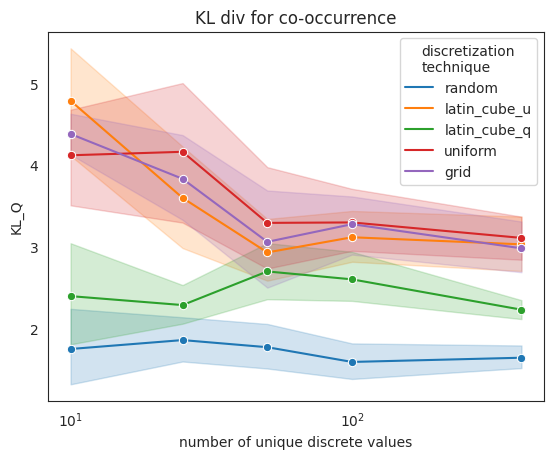

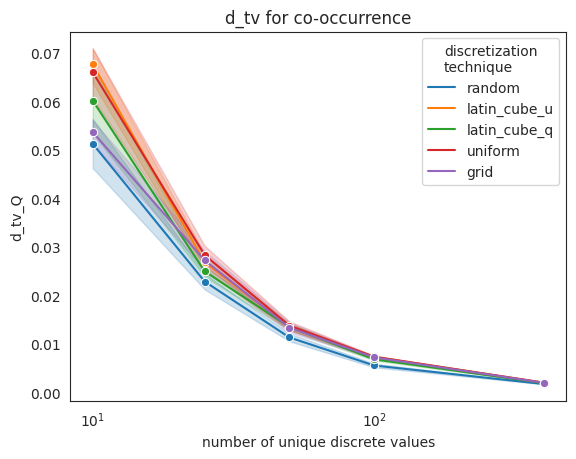

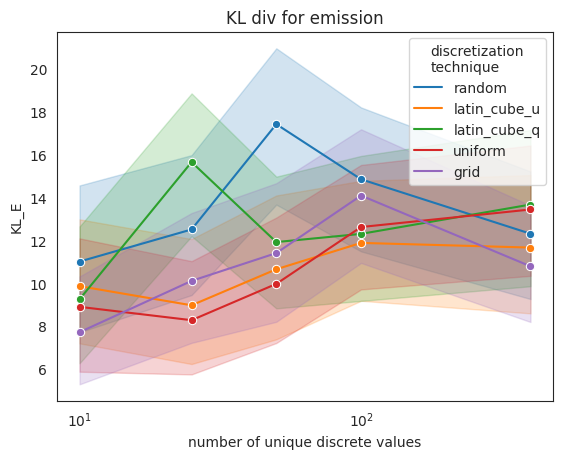

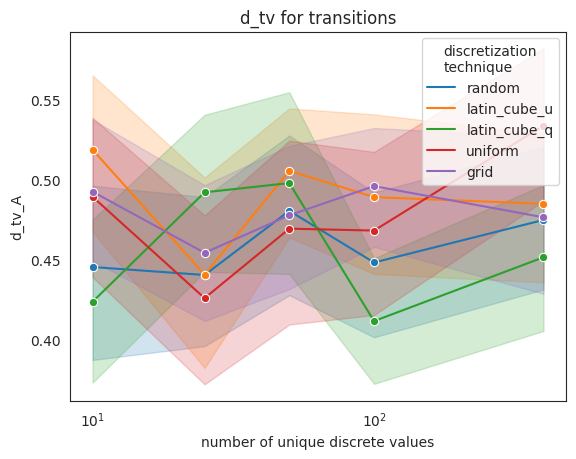

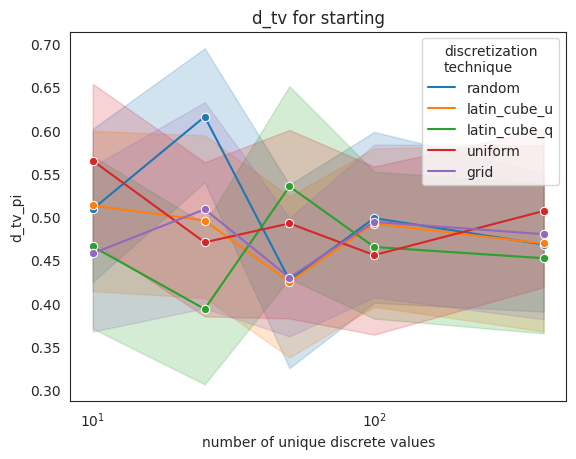

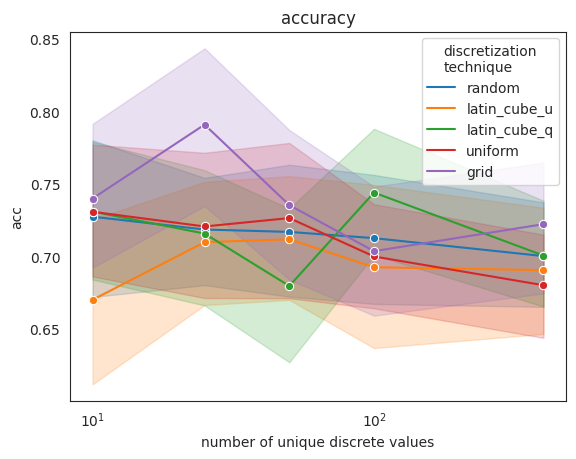

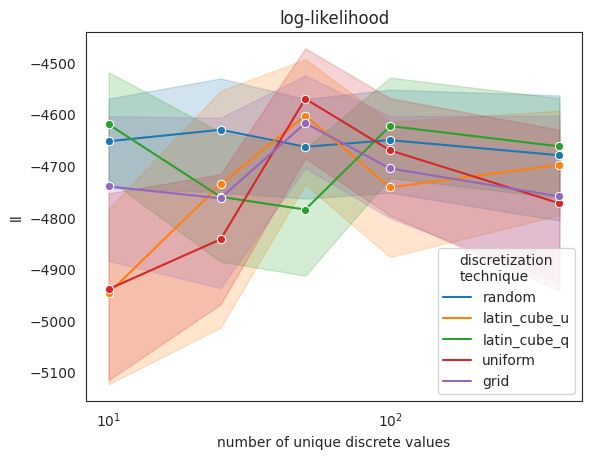

In [11]:
for col in titles.keys():
    sns.lineplot(results, x='n', y=col, hue='disc', marker='o')
    plt.title(titles[col])
    plt.xlabel('number of unique discrete values')
    plt.legend(title="discretization\ntechnique")
    plt.xscale('log')
    plt.savefig(f"{PROJECT_PATH}/theoretical_experiment/plots/2_{col}.png")
    plt.show()